In [1]:
import numpy as np
import seaborn as sns
import categorization as cat
import scipy.spatial.distance as dist
from sklearn.manifold import MDS, TSNE
import matplotlib.pyplot as plt
import sklearn.cluster as cluster
from scipy.cluster.hierarchy import dendrogram
import sklearn.metrics as metrics
import pandas as pd

2023-11-27 22:17:03.024489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 22:17:04.669551: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-27 22:17:04.669674: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-27 22:17:04.669686: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
def print_cluster_stats(tree, hierLabels, exemplars):
    # Adjusted rand score, 1 is perfect, pair counting method
    print("Adjusted Rand score:")
    _ = cat.external_evaluate_over_levels(
        tree, hierLabels, metrics.adjusted_rand_score, verbose=True
    )

    # Mutual information, 1 is perfect, agreement between two partitions
    print("Adjusted Mutual information:")
    _ = cat.external_evaluate_over_levels(
        tree, hierLabels, metrics.adjusted_mutual_info_score, verbose=True
    )

    # V-measure, 1 is perfect, weighted harmonic mean of homogeneity (cluster only includes one class) and completeness (all members in one class)
    print("V-measure:")
    _ = cat.external_evaluate_over_levels(
        tree, hierLabels, metrics.v_measure_score, verbose=True
    )

    # Fowlkes-Mallows, 1 is perfect, geometric mean between precision (TP/TP+FP) and recall (TP/FP+FN)
    print("Fowlkes-Mallows:")
    _ = cat.external_evaluate_over_levels(
        tree, hierLabels, metrics.fowlkes_mallows_score, verbose=True
    )

    # Davies-Bouldin, 0 is best partitioning, signifies average similarity between clusters
    print("Davies-Bouldin:")
    _ = cat.internal_evaluate_over_levels(
        tree,
        exemplars,
        metrics.davies_bouldin_score,
        level=3,
        verbose=True,
    )

    # Silhouette score, 0 is overlapping clusters, +1 is perfect clustering, -1 is wrong clustering
    print("Silhouette score:")
    _ = cat.internal_evaluate_over_levels(
        tree,
        exemplars,
        metrics.silhouette_score,
        level=3,
        verbose=True,
    )

    # Calinski_harabasz, higher is denser well-separated clusters
    print("Calinski-Harabasz:")
    _ = cat.internal_evaluate_over_levels(
        tree,
        exemplars,
        metrics.calinski_harabasz_score,
        level=3,
        verbose=True,
    )

    return None


def print_category_metrics(exemplars, labels, simMat, imgInfo, binary=True):
    superLabels = labels[:, 0]
    basicLabels = labels[:, 1]
    subLabels = labels[:, 2]

    print("Category cue validity = Sum(P(C|fk)) / n")
    print("Superordinate: ")
    cat.calc_cue_validity(exemplars, superLabels, binary=binary, verbose=True)

    print("Basic: ")
    cat.calc_cue_validity(exemplars, basicLabels, binary=binary, verbose=True)

    print("Subordinate: ")
    _ = cat.calc_cue_validity(exemplars, subLabels, binary=binary, verbose=True)
    print()

    print("Category validity = Sum(P(fk|C)) / n")
    print("Superordinate: ")
    cat.calc_category_validity(exemplars, superLabels, binary=binary, verbose=True)

    print("Basic: ")
    cat.calc_category_validity(exemplars, basicLabels, binary=binary, verbose=True)

    print("Subordinate: ")
    _ = cat.calc_category_validity(exemplars, subLabels, binary=binary, verbose=True)
    print()

    print("Collocation (cue validity * category validity)")
    print("Superordinate: ")
    cat.calc_collocation(exemplars, superLabels, binary=binary, verbose=True)

    print("Basic: ")
    cat.calc_collocation(exemplars, basicLabels, binary=binary, verbose=True)

    print("Subordinate: ")
    _ = cat.calc_collocation(exemplars, subLabels, binary=binary, verbose=True)
    print()

    print("Category utility P(C) * Sum(P(Fk|C) ** 2 - P(Fk)**2)")
    print("Superordinate: ")
    cat.calc_category_utility(exemplars, superLabels, binary=binary, verbose=True)

    print("Basic: ")
    cat.calc_category_utility(exemplars, basicLabels, binary=binary, verbose=True)

    print("Subordinate: ")
    _ = cat.calc_category_utility(exemplars, subLabels, binary=binary, verbose=True)
    print()

    print("Cluster index (mean within sim - mean betwen sim)")
    simCluster = cat.SimCluster(simMat=simMat, imgInfo=imgInfo)

    print("Superordinate: ")
    print(simCluster.calculate_index(level="super"))

    print("Basic: ")
    print(simCluster.calculate_index(level="basic"))

    print("Subordinate: ")
    print(simCluster.calculate_index(level="sub"))

In [3]:
# Create labels
superLabels = np.concatenate([np.repeat(i, 400) for i in range(2)])
basicLabels = np.concatenate([np.repeat(i, 200) for i in range(4)])
subLabels = np.concatenate([np.repeat(i, 100) for i in range(8)])

# Concatenate labels into columns
hierLabels = np.concatenate([superLabels, basicLabels, subLabels]).reshape(3, -1).T

In [4]:
# Load csv
imgInfo = pd.read_csv("./deepCatsImgs.csv")

# Sort the rows by super, basic, then sub (regardless of set)
imgInfo = imgInfo.sort_values(by=["super", "basic", "sub"])
imgInfo = imgInfo.reset_index(drop=True)

# Demo different exemplar generation algos


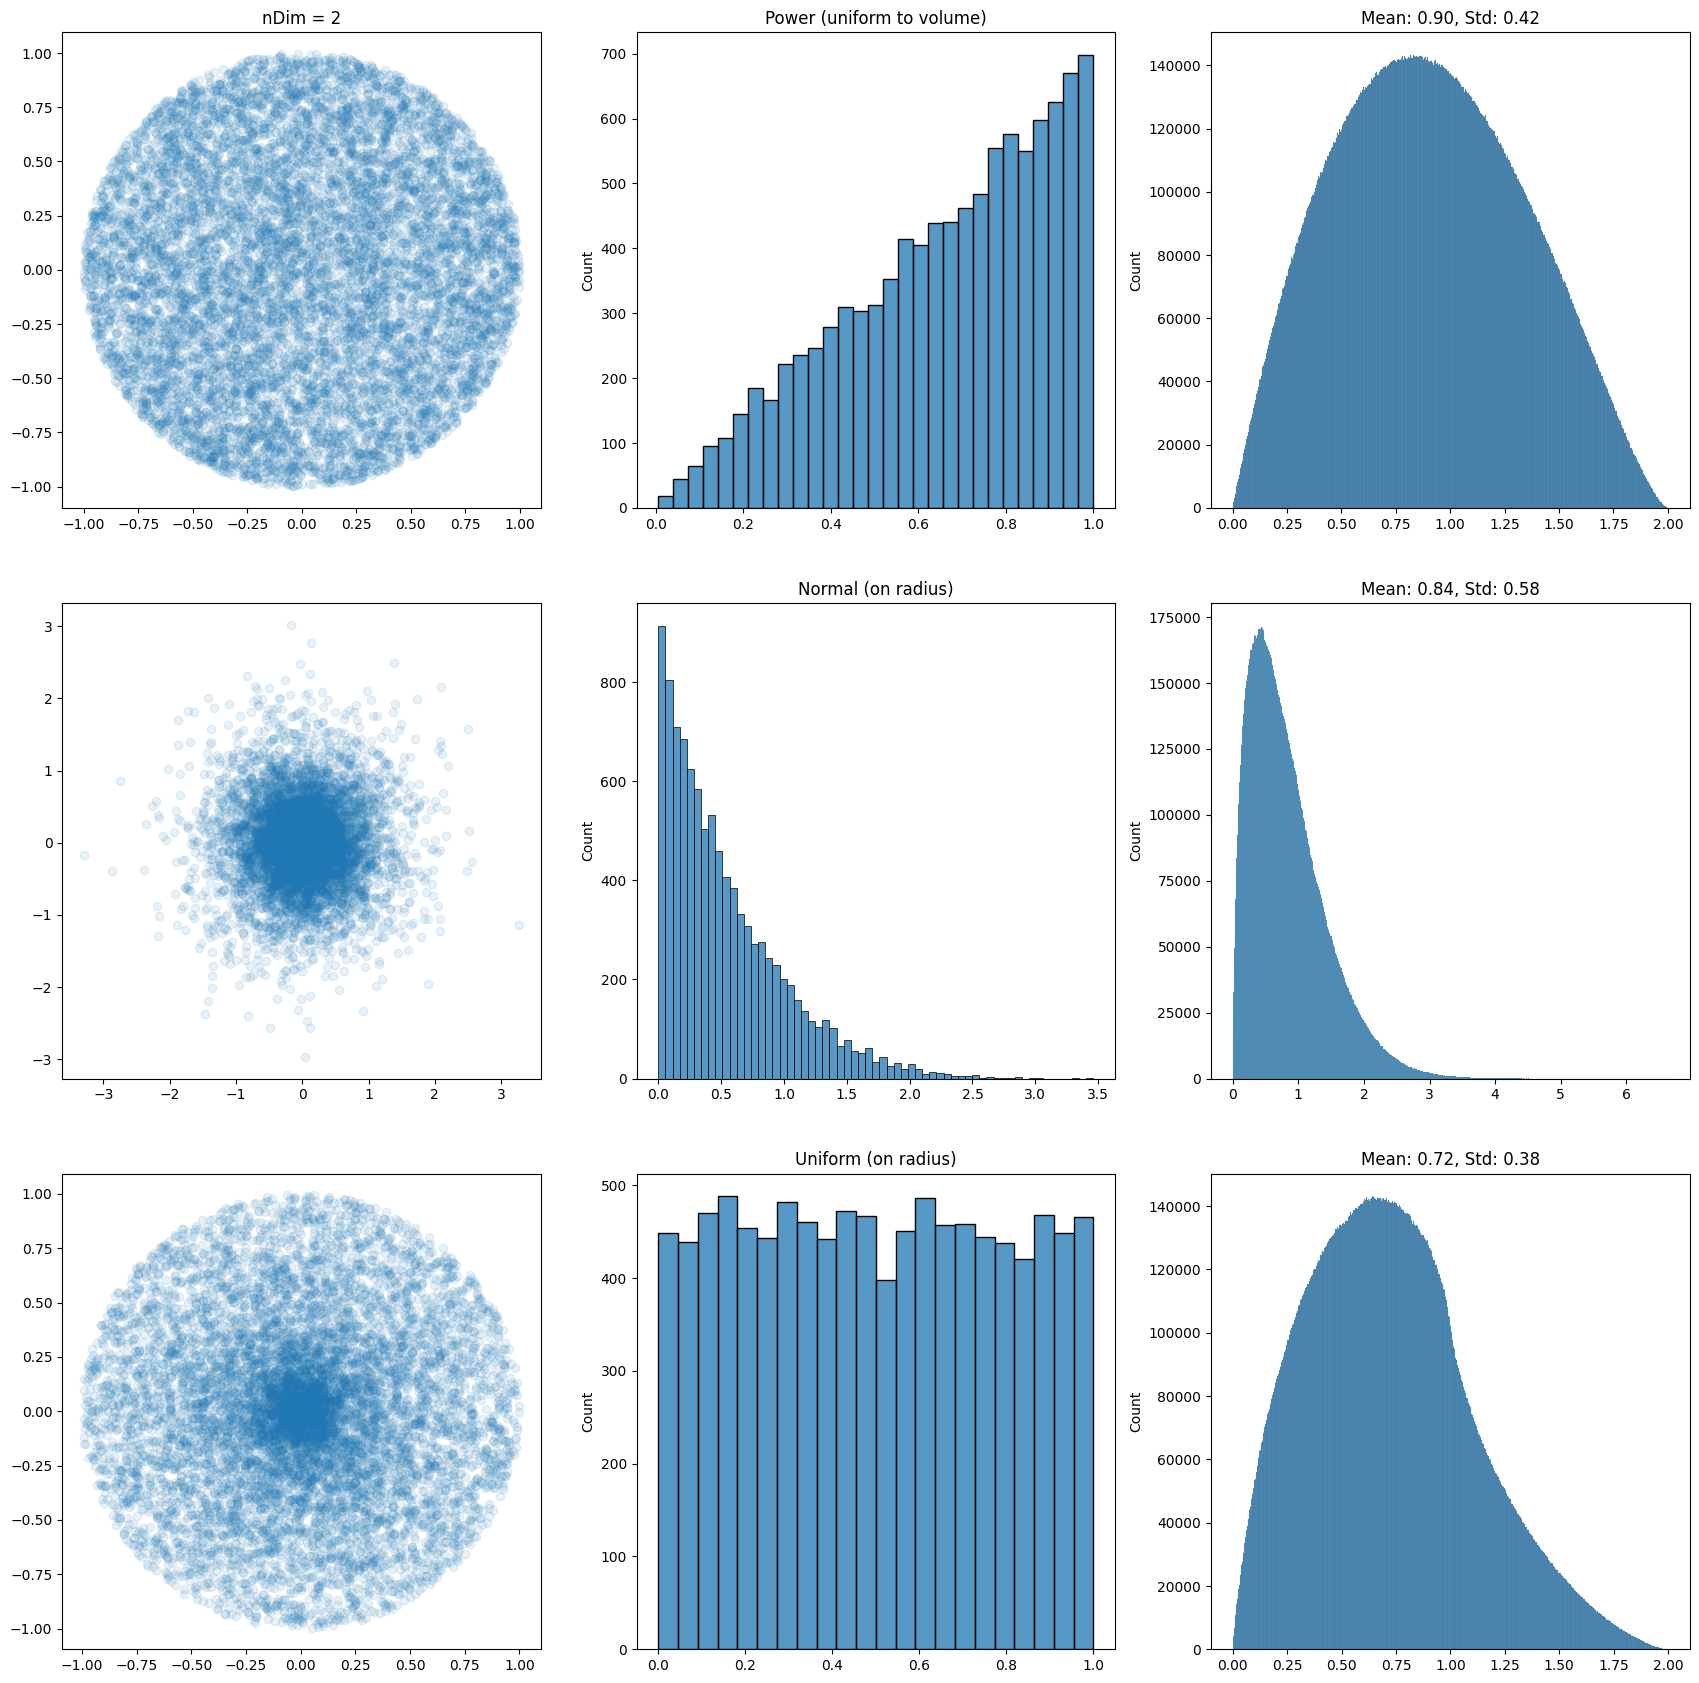

In [2]:
# Generate exemplars
nExemplars = 10_000
center = np.zeros((2,))
radius = 1
relu = False

powerExemplars = cat.exemplar_maker(
    nExemplars, center, radius=radius, radius_density="power", relu=relu
)
normalExemplars = cat.exemplar_maker(
    nExemplars, center, radius=radius, radius_density="normal", relu=relu
)
uniformExemplars = cat.exemplar_maker(
    nExemplars, center, radius=radius, radius_density="uniform", relu=relu
)

# Calculate similarity matrix
powerSims = dist.pdist(powerExemplars, metric="euclidean")
normalSims = dist.pdist(normalExemplars, metric="euclidean")
uniformSims = dist.pdist(uniformExemplars, metric="euclidean")

# Plot scatter
fig, axs = plt.subplots(3, 3, figsize=(21, 21))

axs[0][0].scatter(powerExemplars[:, 0], powerExemplars[:, 1], alpha=0.1)
_ = sns.histplot(np.linalg.norm(powerExemplars, axis=1), ax=axs[0][1])
_ = sns.histplot(powerSims, ax=axs[0][2])
_ = axs[0][0].set_title("nDim = 2")
_ = axs[0][1].set_title("Power (uniform to volume)")
_ = axs[0][2].set_title(f"Mean: {np.mean(powerSims):.2f}, Std: {np.std(powerSims):.2f}")

axs[1][0].scatter(normalExemplars[:, 0], normalExemplars[:, 1], alpha=0.1)
_ = sns.histplot(np.linalg.norm(normalExemplars, axis=1), ax=axs[1][1])
_ = sns.histplot(normalSims, ax=axs[1][2])
_ = axs[1][1].set_title("Normal (on radius)")
_ = axs[1][2].set_title(
    f"Mean: {np.mean(normalSims):.2f}, Std: {np.std(normalSims):.2f}"
)

axs[2][0].scatter(uniformExemplars[:, 0], uniformExemplars[:, 1], alpha=0.1)
_ = sns.histplot(np.linalg.norm(uniformExemplars, axis=1), ax=axs[2][1])
_ = sns.histplot(uniformSims, ax=axs[2][2])
_ = axs[2][1].set_title("Uniform (on radius)")
_ = axs[2][2].set_title(
    f"Mean: {np.mean(uniformSims):.2f}, Std: {np.std(uniformSims):.2f}"
)

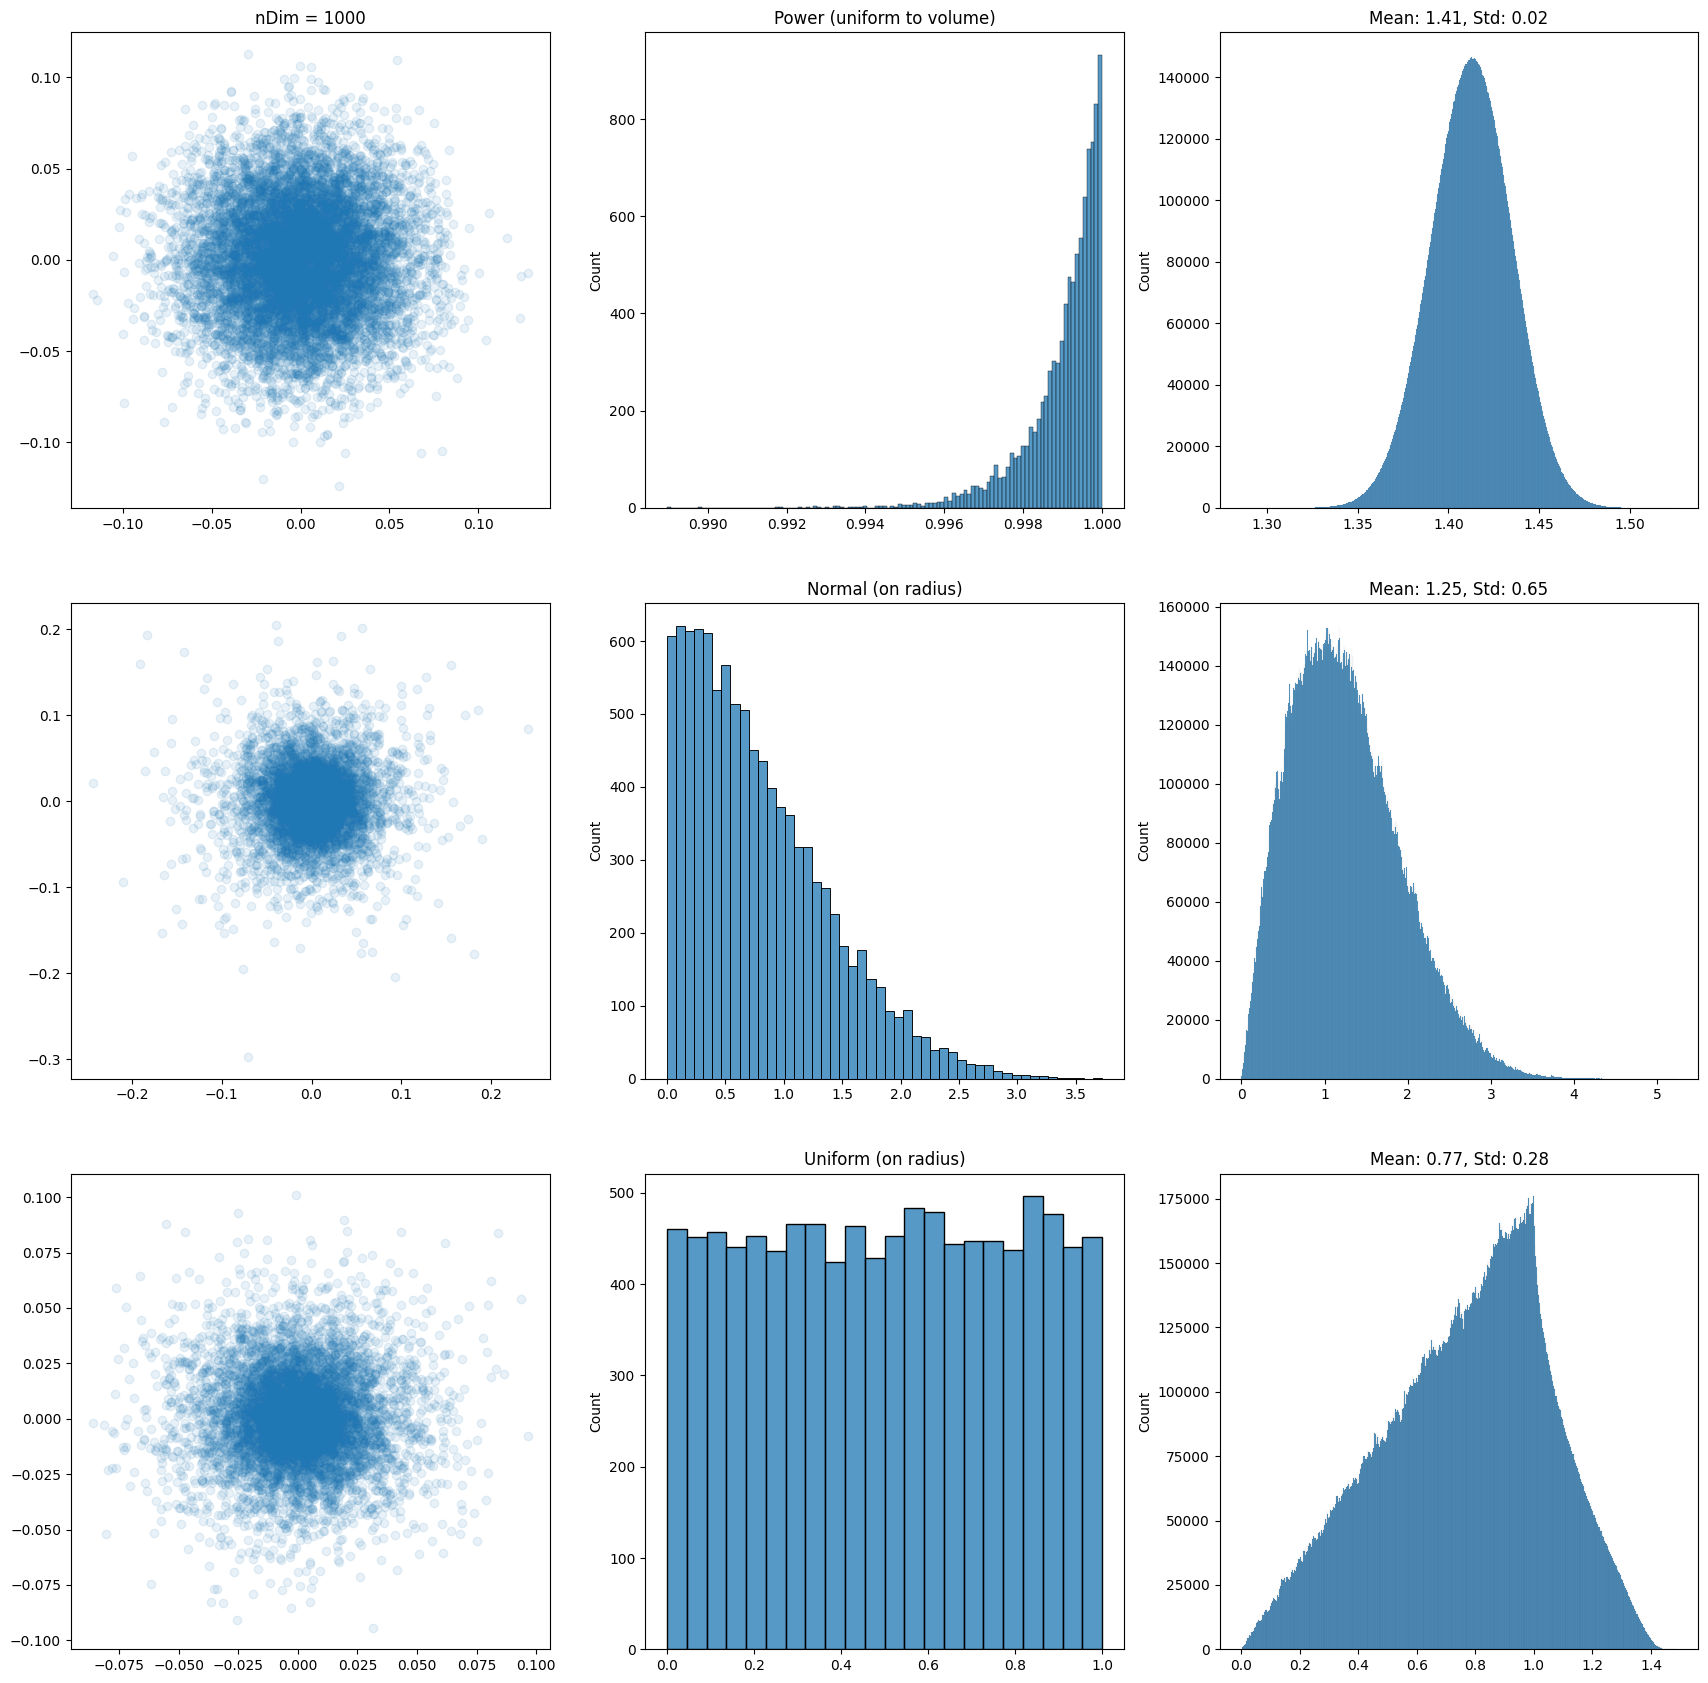

In [3]:
# Generate exemplars
nExemplars = 10_000
center = np.zeros((1000,))
radius = 1

powerExemplars = cat.exemplar_maker(
    nExemplars, center, radius=radius, radius_density="power", relu=relu
)
normalExemplars = cat.exemplar_maker(
    nExemplars, center, radius=radius, radius_density="normal", relu=relu
)
uniformExemplars = cat.exemplar_maker(
    nExemplars, center, radius=radius, radius_density="uniform", relu=relu
)

# Calculate similarity matrix
powerSims = dist.pdist(powerExemplars, metric="euclidean")
normalSims = dist.pdist(normalExemplars, metric="euclidean")
uniformSims = dist.pdist(uniformExemplars, metric="euclidean")

# Plot scatter
fig, axs = plt.subplots(3, 3, figsize=(21, 21))

axs[0][0].scatter(powerExemplars[:, 0], powerExemplars[:, 1], alpha=0.1)
_ = sns.histplot(np.linalg.norm(powerExemplars, axis=1), ax=axs[0][1])
_ = sns.histplot(powerSims, ax=axs[0][2])
_ = axs[0][0].set_title("nDim = 1000")
_ = axs[0][1].set_title("Power (uniform to volume)")
_ = axs[0][2].set_title(f"Mean: {np.mean(powerSims):.2f}, Std: {np.std(powerSims):.2f}")

axs[1][0].scatter(normalExemplars[:, 0], normalExemplars[:, 1], alpha=0.1)
_ = sns.histplot(np.linalg.norm(normalExemplars, axis=1), ax=axs[1][1])
_ = sns.histplot(normalSims, ax=axs[1][2])
_ = axs[1][1].set_title("Normal (on radius)")
_ = axs[1][2].set_title(
    f"Mean: {np.mean(normalSims):.2f}, Std: {np.std(normalSims):.2f}"
)

axs[2][0].scatter(uniformExemplars[:, 0], uniformExemplars[:, 1], alpha=0.1)
_ = sns.histplot(np.linalg.norm(uniformExemplars, axis=1), ax=axs[2][1])
_ = sns.histplot(uniformSims, ax=axs[2][2])
_ = axs[2][1].set_title("Uniform (on radius)")
_ = axs[2][2].set_title(
    f"Mean: {np.mean(uniformSims):.2f}, Std: {np.std(uniformSims):.2f}"
)

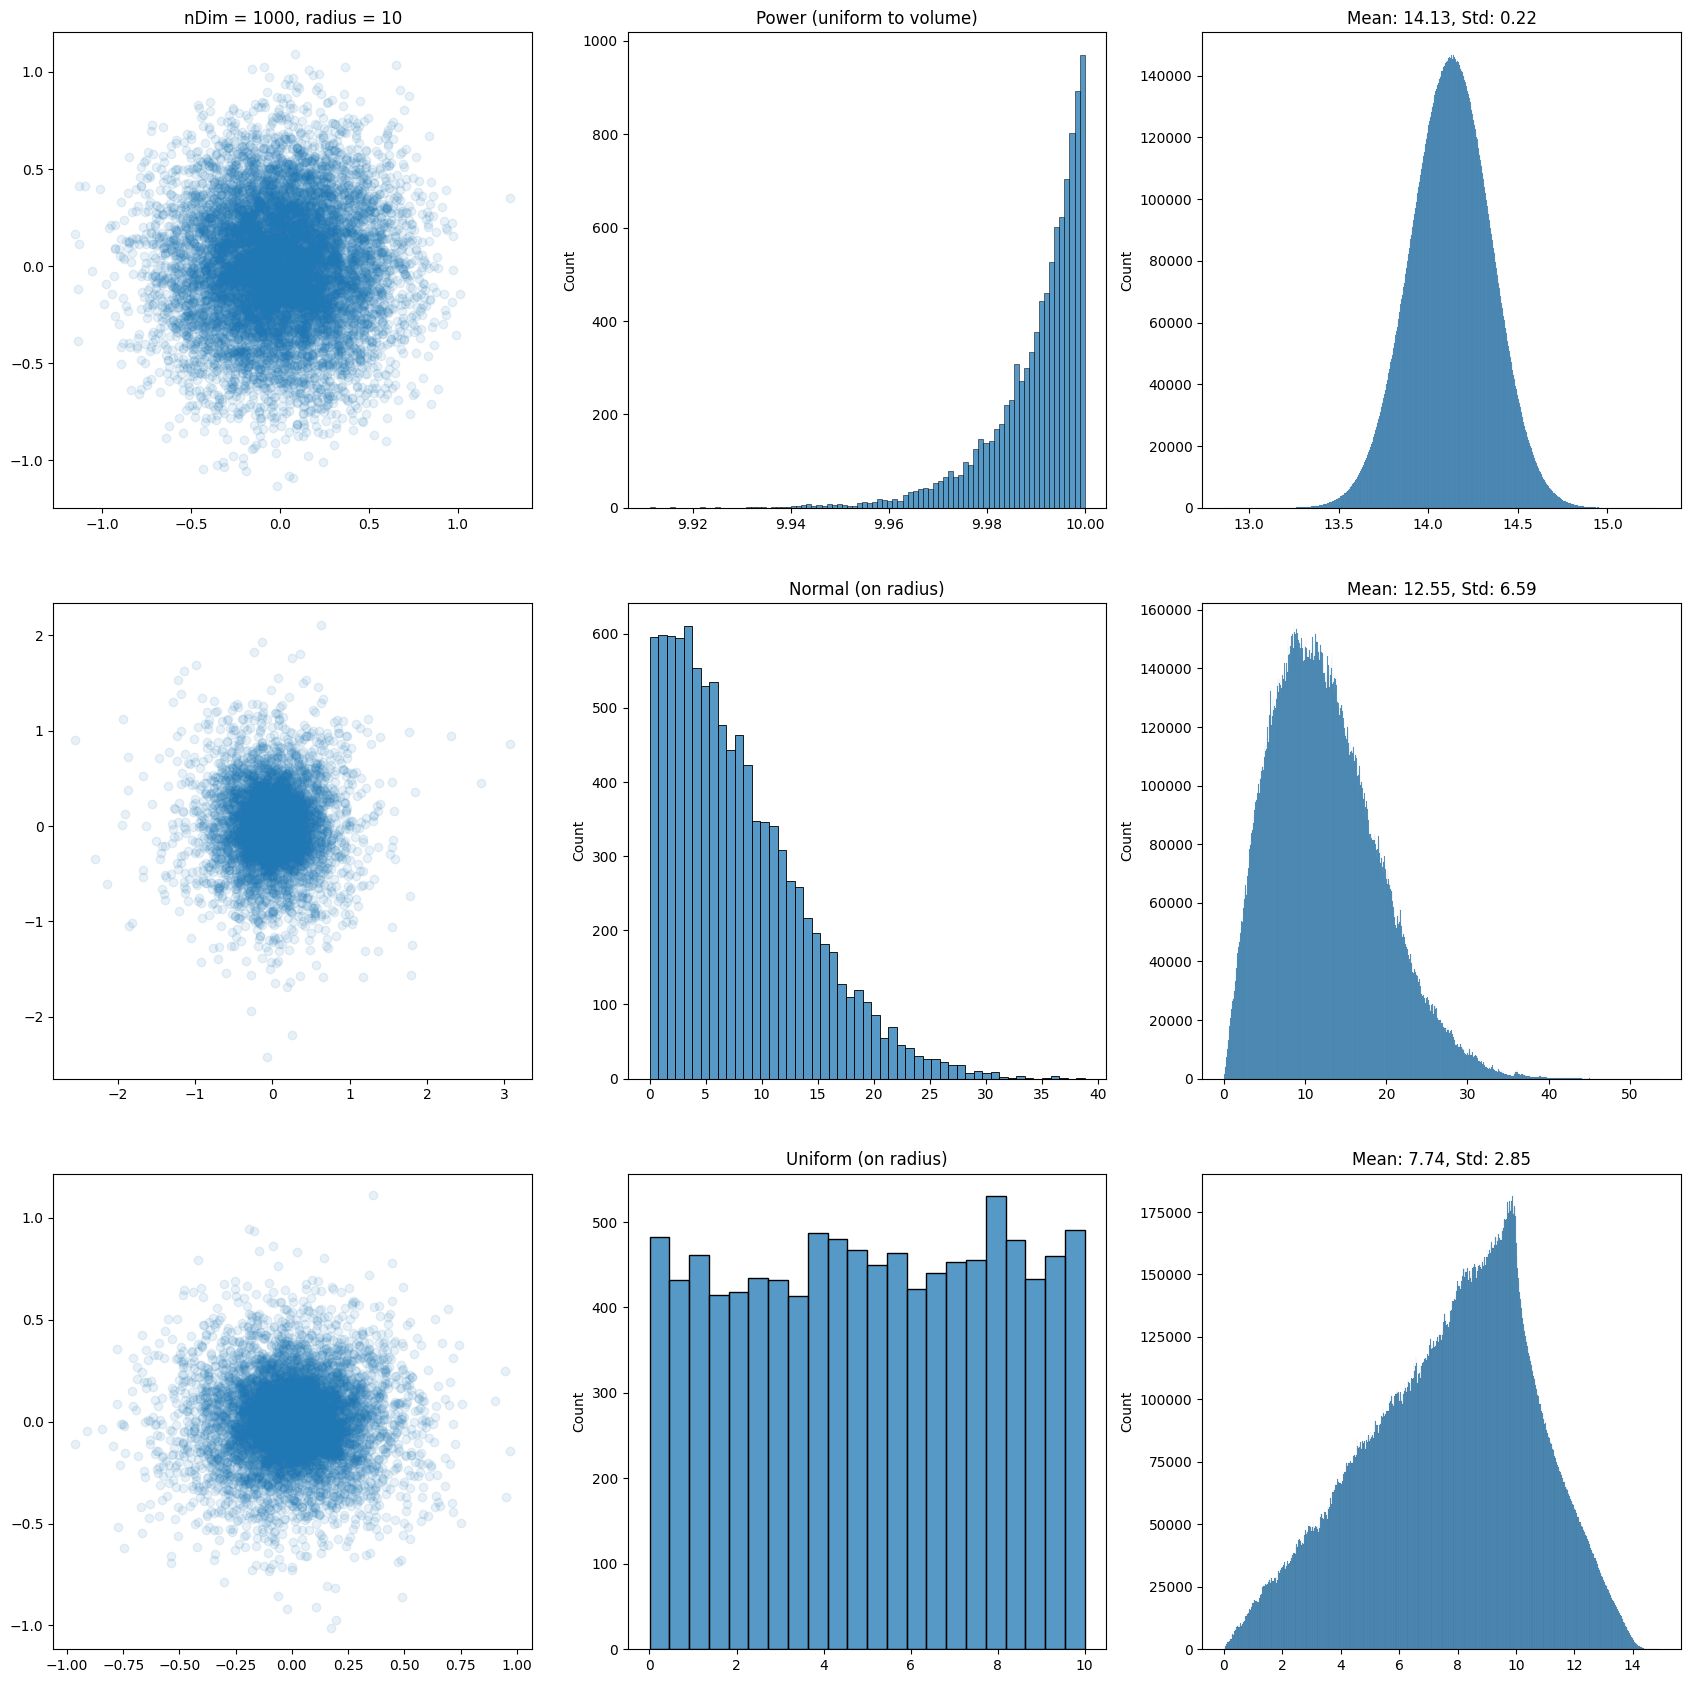

In [4]:
# Generate exemplars
nExemplars = 10_000
center = np.zeros((1000,))
radius = 10

powerExemplars = cat.exemplar_maker(
    nExemplars, center, radius=radius, radius_density="power", relu=relu
)
normalExemplars = cat.exemplar_maker(
    nExemplars, center, radius=radius, radius_density="normal", relu=relu
)
uniformExemplars = cat.exemplar_maker(
    nExemplars, center, radius=radius, radius_density="uniform", relu=relu
)

# Calculate similarity matrix
powerSims = dist.pdist(powerExemplars, metric="euclidean")
normalSims = dist.pdist(normalExemplars, metric="euclidean")
uniformSims = dist.pdist(uniformExemplars, metric="euclidean")

# Plot scatter
fig, axs = plt.subplots(3, 3, figsize=(21, 21))

axs[0][0].scatter(powerExemplars[:, 0], powerExemplars[:, 1], alpha=0.1)
_ = sns.histplot(np.linalg.norm(powerExemplars, axis=1), ax=axs[0][1])
_ = sns.histplot(powerSims, ax=axs[0][2])
_ = axs[0][0].set_title("nDim = 1000, radius = 10")
_ = axs[0][1].set_title("Power (uniform to volume)")
_ = axs[0][2].set_title(f"Mean: {np.mean(powerSims):.2f}, Std: {np.std(powerSims):.2f}")

axs[1][0].scatter(normalExemplars[:, 0], normalExemplars[:, 1], alpha=0.1)
_ = sns.histplot(np.linalg.norm(normalExemplars, axis=1), ax=axs[1][1])
_ = sns.histplot(normalSims, ax=axs[1][2])
_ = axs[1][1].set_title("Normal (on radius)")
_ = axs[1][2].set_title(
    f"Mean: {np.mean(normalSims):.2f}, Std: {np.std(normalSims):.2f}"
)

axs[2][0].scatter(uniformExemplars[:, 0], uniformExemplars[:, 1], alpha=0.1)
_ = sns.histplot(np.linalg.norm(uniformExemplars, axis=1), ax=axs[2][1])
_ = sns.histplot(uniformSims, ax=axs[2][2])
_ = axs[2][1].set_title("Uniform (on radius)")
_ = axs[2][2].set_title(
    f"Mean: {np.mean(uniformSims):.2f}, Std: {np.std(uniformSims):.2f}"
)

# Sweep across number of dimension and plot the effect on mean/SD similarity


In [5]:
nExemplars = 1_000
radius = 1
nDims = [2, 10, 100, 1000, 10000, 100000]

meanDists = []
stdDists = []
for dim in nDims:
    # Create a center
    center = np.zeros((dim,))

    # Generate exemplars
    dimExemplars = cat.exemplar_maker(
        nExemplars, center, radius=radius, radius_density="power", relu=True
    )

    # Calculate dissimilarity matrix
    dimSims = dist.pdist(dimExemplars, metric="euclidean")

    # Calculate mean and std
    mean = np.mean(dimSims)
    std = np.std(dimSims)

    # Append to list
    meanDists.append(mean)
    stdDists.append(std)

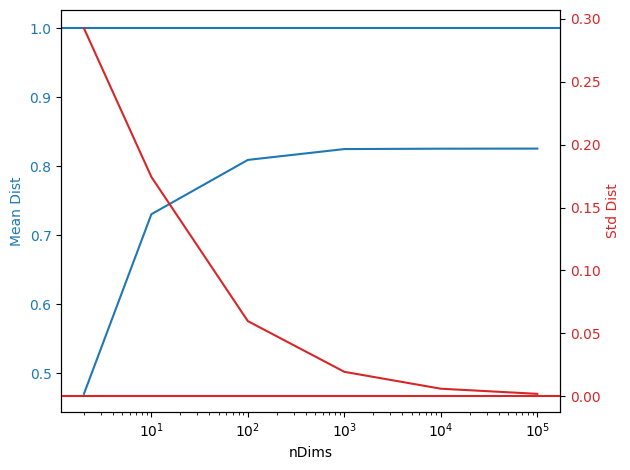

In [7]:
# Plot mean and std of dissimilarity over nDims on one plot
fig, ax1 = plt.subplots()

color = "tab:blue"
ax1.set_xlabel("nDims")
ax1.set_ylabel("Mean Dist", color=color)
ax1.plot(nDims, meanDists, color=color)
ax1.tick_params(axis="y", labelcolor=color)

# Draw a horizontal line at y=1
ax1.axhline(y=1, color=color, linestyle="-")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = "tab:red"
ax2.set_ylabel("Std Dist", color=color)  # we already handled the x-label with ax1
ax2.plot(nDims, stdDists, color=color)
ax2.tick_params(axis="y", labelcolor=color)

# Draw a horizontal line at y=0
ax2.axhline(y=0, color=color, linestyle="-")

# Set x axis to log scale
ax1.set_xscale("log")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Simulate full categories with subordinates


In [3]:
# Create simulated categories with category separation all the way down
subExemplars, subCentroids = cat.make_categories(
    cat_rad=1,
    super_rad=1,
    basic_rad=0.5,
    sub_rad=0.25,
    nFeatures=1024,
    nImages=100,
    relu=True,
    radius_density="power",
)

/data/venv/research2/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


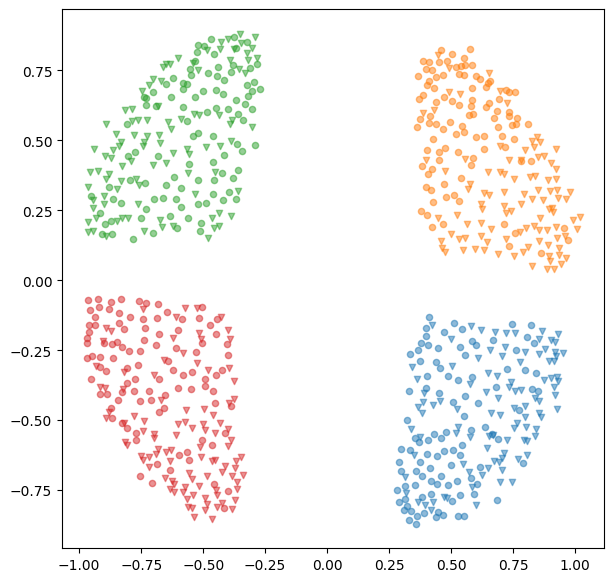

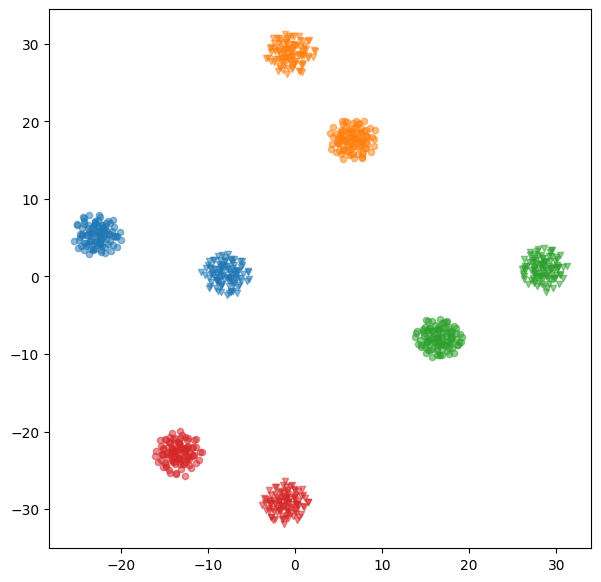

In [8]:
# Demonstrate that divisive hierarchical clustering can reconstruct the hierarchy
subClusters = cat.diana(subExemplars, "euclidean", max_clusters=None)
subLinkage = subClusters.linkage_matrix()

# Calculate dissimilarity matrix
subDistMat = dist.squareform(dist.pdist(subExemplars, metric="euclidean"))
subSimMat = 1 / (1 + subDistMat)

# Do MDS
tmp = MDS(
    n_components=2,
    dissimilarity="precomputed",
)
subMDS = tmp.fit_transform(subDistMat)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Every 200 dots change colors
colors = sns.color_palette(n_colors=4)
for i in range(4):
    # Every 100 dots change shapes
    for j in range(2):
        ax.scatter(
            subMDS[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 0],
            subMDS[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 1],
            s=20,
            alpha=0.5,
            color=colors[i],
            marker="o" if j == 0 else "v",
        )

# Do tsne
tmp = TSNE(n_components=2, metric="precomputed", init="random")
subTSNE = tmp.fit_transform(subDistMat)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Every 200 dots change colors
for i in range(4):
    # Every 100 dots change shapes
    for j in range(2):
        ax.scatter(
            subTSNE[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 0],
            subTSNE[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 1],
            s=20,
            alpha=0.5,
            color=colors[i],
            marker="o" if j == 0 else "v",
        )

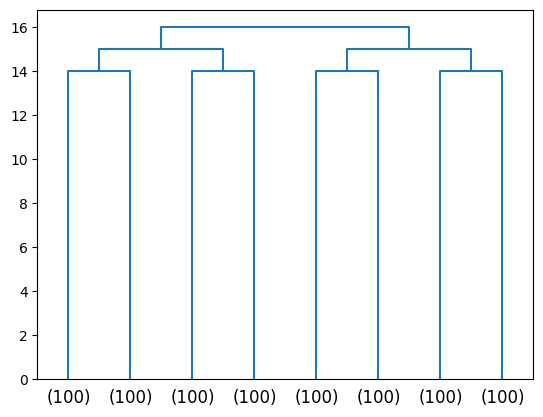

In [9]:
_ = dendrogram(subLinkage, labels=subLabels, truncate_mode="level", p=2)

In [39]:
print_cluster_stats(subClusters.tree, hierLabels, subExemplars)

Adjusted Rand score:
Level 1: 1.0
Level 2: 1.0
Level 3: 1.0
Adjusted Mutual information:
Level 1: 1.0
Level 2: 1.0
Level 3: 1.0
V-measure:
Level 1: 1.0
Level 2: 1.0
Level 3: 1.0
Fowlkes-Mallows:
Level 1: 1.0
Level 2: 1.0
Level 3: 1.0
Davies-Bouldin:
Level 1: 1.404851548863056
Level 2: 2.2729403156983747
Level 3: 4.094980038037752
Silhouette score:
Level 1: 0.29664623737335205
Level 2: 0.14894568920135498
Level 3: 0.049938250333070755
Calinski-Harabasz:
Level 1: 404.0897874236565
Level 2: 211.680661252153
Level 3: 102.38881295067524


In [19]:
print_category_metrics(subExemplars, hierLabels, subSimMat, imgInfo)

Category cue validity = Sum(P(C|fk)) / n
Superordinate: 
Category:  0 Cue validity:  0.2456628417968745
Category:  1 Cue validity:  0.25374877929687484
Basic: 
Category:  0 Cue validity:  0.12283325195312493
Category:  1 Cue validity:  0.12282958984374998
Category:  2 Cue validity:  0.12727294921875004
Category:  3 Cue validity:  0.12647583007812502
Subordinate: 
Category:  0 Cue validity:  0.061433105468750006
Category:  1 Cue validity:  0.061400146484375084
Category:  2 Cue validity:  0.061446533203124945
Category:  3 Cue validity:  0.06138305664062495
Category:  4 Cue validity:  0.06277343750000001
Category:  5 Cue validity:  0.06449951171875004
Category:  6 Cue validity:  0.0629638671875
Category:  7 Cue validity:  0.06351196289062497

Category validity = Sum(P(fk|C)) / n
Superordinate: 
Category:  0  Validity:  0.491325683593749
Category:  1  Validity:  0.5074975585937497
Basic: 
Category:  0  Validity:  0.4913330078124997
Category:  1  Validity:  0.4913183593749999
Category:  2  

# Low Dim full hierarchy


In [12]:
# Create simulated categories with category separation all the way down
subSmallExemplars, subSmallCentroids = cat.make_categories(
    cat_rad=1,
    super_rad=1,
    basic_rad=0.5,
    sub_rad=0.25,
    nFeatures=3,
    nImages=100,
    radius_density="power",
    relu=False,  # has to for low dimensions
)

/data/venv/research2/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


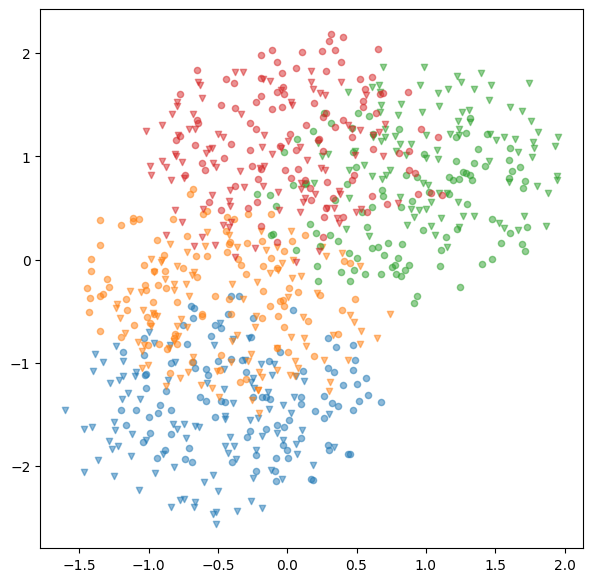

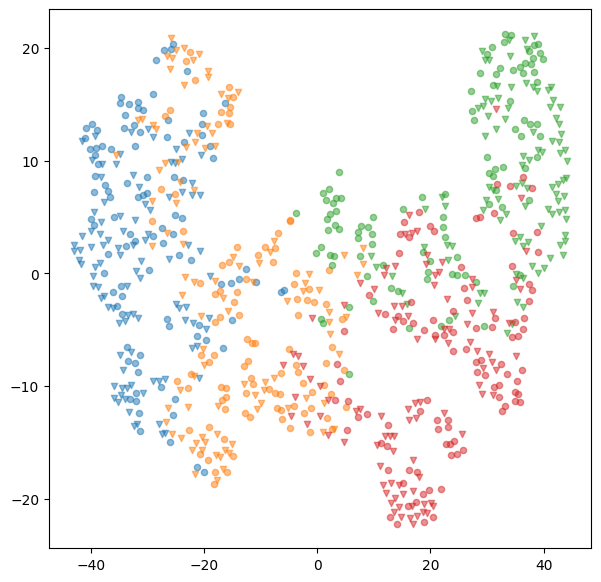

In [13]:
# Demonstrate that divisive hierarchical clustering can reconstruct the hierarchy
subSmallClusters = cat.diana(subSmallExemplars, "euclidean", max_clusters=None)
subSmallLinkage = subSmallClusters.linkage_matrix()

# Calculate dissimilarity matrix
subSmallDistMat = dist.squareform(dist.pdist(subSmallExemplars, metric="euclidean"))
subSmallSimMat = 1 / (1 + subSmallDistMat)

# Do MDS
tmp = MDS(
    n_components=2,
    dissimilarity="precomputed",
)
subSmallMDS = tmp.fit_transform(subSmallDistMat)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Every 200 dots change colors
colors = sns.color_palette(n_colors=4)
for i in range(4):
    # Every 100 dots change shapes
    for j in range(2):
        ax.scatter(
            subSmallMDS[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 0],
            subSmallMDS[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 1],
            s=20,
            alpha=0.5,
            color=colors[i],
            marker="o" if j == 0 else "v",
        )

# Do tsne
tmp = TSNE(n_components=2, metric="precomputed", init="random")
subSmallTSNE = tmp.fit_transform(subSmallDistMat)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Every 200 dots change colors
for i in range(4):
    # Every 100 dots change shapes
    for j in range(2):
        ax.scatter(
            subSmallTSNE[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 0],
            subSmallTSNE[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 1],
            s=20,
            alpha=0.5,
            color=colors[i],
            marker="o" if j == 0 else "v",
        )

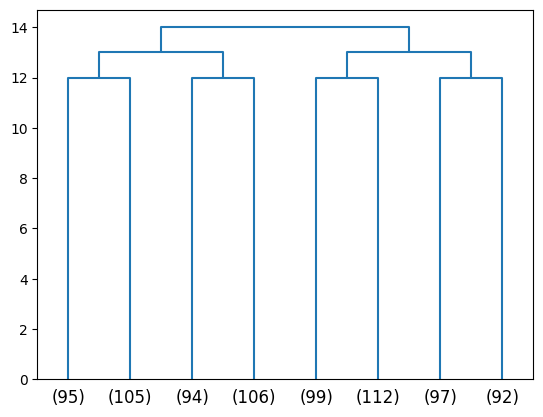

In [37]:
_ = dendrogram(subSmallLinkage, labels=subLabels, truncate_mode="level", p=2)

In [15]:
print_cluster_stats(subSmallClusters.tree, hierLabels, subSmallExemplars)

Adjusted Rand score:
Level 1: 0.8142748621054631
Level 2: 0.5012396895826594
Level 3: 0.25405514726895917
Adjusted Mutual information:
Level 1: 0.7360388061224794
Level 2: 0.5514094693790104
Level 3: 0.4353747571568064
V-measure:
Level 1: 0.7362776586326009
Level 2: 0.553242338218507
Level 3: 0.44388805665207615
Fowlkes-Mallows:
Level 1: 0.9072348974765011
Level 2: 0.6260469925814705
Level 3: 0.3485294983026277
Davies-Bouldin:
Level 1: 0.8572620366201463
Level 2: 1.352083926414093
Level 3: 1.4067544158295837
Silhouette score:
Level 1: 0.4470463693141937
Level 2: 0.2529265880584717
Level 3: 0.2195773869752884
Calinski-Harabasz:
Level 1: 963.7737766505466
Level 2: 605.678096666316
Level 3: 425.83479483211187


In [18]:
print_category_metrics(
    subSmallExemplars, hierLabels, subSmallSimMat, imgInfo, binary=False
)

Category cue validity = Sum(P(C|fk)) / n
Superordinate: 
Category:  0 Cue validity:  0.44814341840444194
Category:  1 Cue validity:  0.44814341840444194
Basic: 
Category:  0 Cue validity:  0.38191861347655737
Category:  1 Cue validity:  0.1848912870702848
Category:  2 Cue validity:  0.466683684793668
Category:  3 Cue validity:  0.42324739101130376
Subordinate: 
Category:  0 Cue validity:  0.21537247171475793
Category:  1 Cue validity:  0.23576750081500533
Category:  2 Cue validity:  0.17187569650618947
Category:  3 Cue validity:  0.10540887322620991
Category:  4 Cue validity:  0.2686281472145808
Category:  5 Cue validity:  0.318825742890912
Category:  6 Cue validity:  0.27980344024055454
Category:  7 Cue validity:  0.2574275187394164

Category validity = Sum(P(fk|C)) / n
Superordinate: 
Category:  0  Validity:  0.6041496793429056
Category:  1  Validity:  0.6459140479564667
Basic: 
Category:  0  Validity:  0.7414595087369283
Category:  1  Validity:  0.46683987975120544
Category:  2  Val

# Simulate full categories with normal radius


In [26]:
subNormalExemplars, _ = cat.make_categories(
    cat_rad=1,
    super_rad=1,
    basic_rad=0.5,
    sub_rad=0.25,
    nFeatures=1024,
    nImages=100,
    relu=True,
    radius_density="normal",
)

/data/venv/research2/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


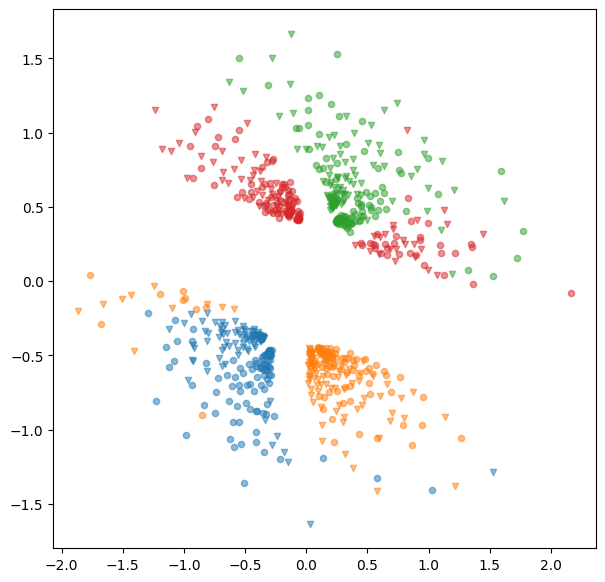

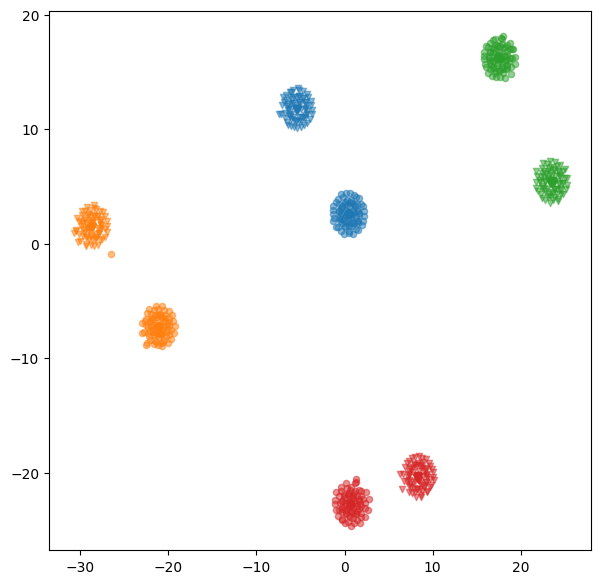

In [27]:
# Demonstrate that divisive hierarchical clustering can reconstruct the hierarchy
subNormalClusters = cat.diana(subNormalExemplars, "euclidean", max_clusters=None)
subNormalLinkage = subNormalClusters.linkage_matrix()

# Calculate dissimilarity matrix
subNormalDistMat = dist.squareform(dist.pdist(subNormalExemplars, metric="euclidean"))
subNormalSimMat = 1 / (1 + subNormalDistMat)

# Do MDS
tmp = MDS(
    n_components=2,
    dissimilarity="precomputed",
)
subNormalMDS = tmp.fit_transform(subNormalDistMat)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Every 200 dots change colors
colors = sns.color_palette(n_colors=4)
for i in range(4):
    # Every 100 dots change shapes
    for j in range(2):
        ax.scatter(
            subNormalMDS[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 0],
            subNormalMDS[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 1],
            s=20,
            alpha=0.5,
            color=colors[i],
            marker="o" if j == 0 else "v",
        )

# Do tsne
tmp = TSNE(n_components=2, metric="precomputed", init="random")
subNormalTSNE = tmp.fit_transform(subNormalDistMat)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Every 200 dots change colors
for i in range(4):
    # Every 100 dots change shapes
    for j in range(2):
        ax.scatter(
            subNormalTSNE[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 0],
            subNormalTSNE[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 1],
            s=20,
            alpha=0.5,
            color=colors[i],
            marker="o" if j == 0 else "v",
        )

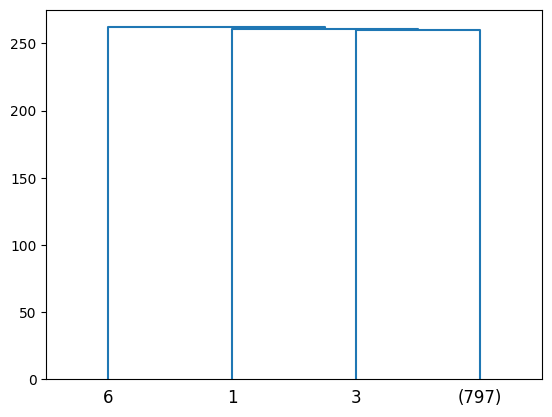

In [28]:
_ = dendrogram(subNormalLinkage, labels=subLabels, truncate_mode="level", p=2)

In [29]:
print_cluster_stats(subNormalClusters.tree, hierLabels, subNormalExemplars)

Adjusted Rand score:
Level 1: 0.0
Level 2: -2.082465606628536e-06
Level 3: -3.563044635497317e-06
Adjusted Mutual information:
Level 1: 1.6610608852869483e-16
Level 2: -2.2372440645386085e-06
Level 3: -0.00020956438080122717
V-measure:
Level 1: 0.0024680570151263234
Level 2: 0.004936125107531691
Level 3: 0.005769528589502714
Fowlkes-Mallows:
Level 1: 0.7057802648330319
Level 2: 0.4978104465925987
Level 3: 0.35067655148757937
Davies-Bouldin:
Level 1: 0.39153560170457885
Level 2: 0.4144783038313105
Level 3: 1.1937661860635151
Silhouette score:
Level 1: 0.49130165576934814
Level 2: 0.44623321294784546
Level 3: 0.4196048676967621
Calinski-Harabasz:
Level 1: 6.041007745015461
Level 2: 5.5882469544093505
Level 3: 5.246791186205892


In [30]:
print_category_metrics(subNormalExemplars, hierLabels, subNormalSimMat, imgInfo)

Category cue validity = Sum(P(C|fk)) / n
Superordinate: 
Category:  0 Cue validity:  0.2518701171875
Category:  1 Cue validity:  0.2512438964843747
Basic: 
Category:  0 Cue validity:  0.12584716796874995
Category:  1 Cue validity:  0.12602294921874987
Category:  2 Cue validity:  0.125953369140625
Category:  3 Cue validity:  0.12529052734374999
Subordinate: 
Category:  0 Cue validity:  0.06205932617187503
Category:  1 Cue validity:  0.0637878417968749
Category:  2 Cue validity:  0.06348388671875
Category:  3 Cue validity:  0.06253906249999998
Category:  4 Cue validity:  0.06263061523437499
Category:  5 Cue validity:  0.06332275390624999
Category:  6 Cue validity:  0.06303588867187497
Category:  7 Cue validity:  0.062254638671874994

Category validity = Sum(P(fk|C)) / n
Superordinate: 
Category:  0  Validity:  0.503740234375
Category:  1  Validity:  0.5024877929687493
Basic: 
Category:  0  Validity:  0.5033886718749998
Category:  1  Validity:  0.5040917968749995
Category:  2  Validity:  

# Simulate full categories with normal radius but use GCM Sim


/data/venv/research2/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


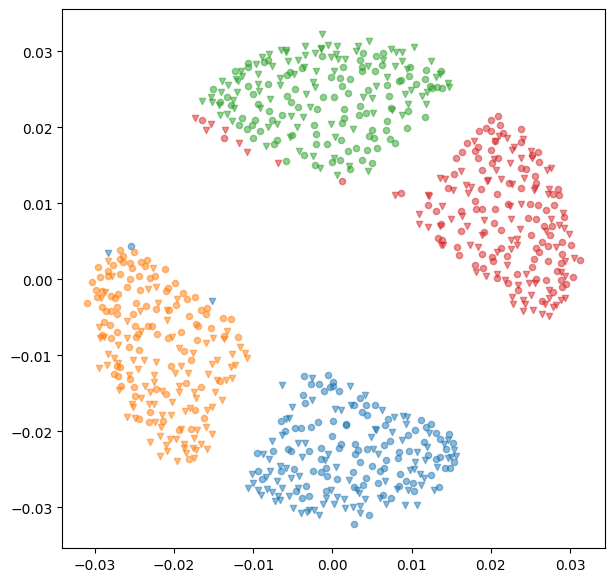

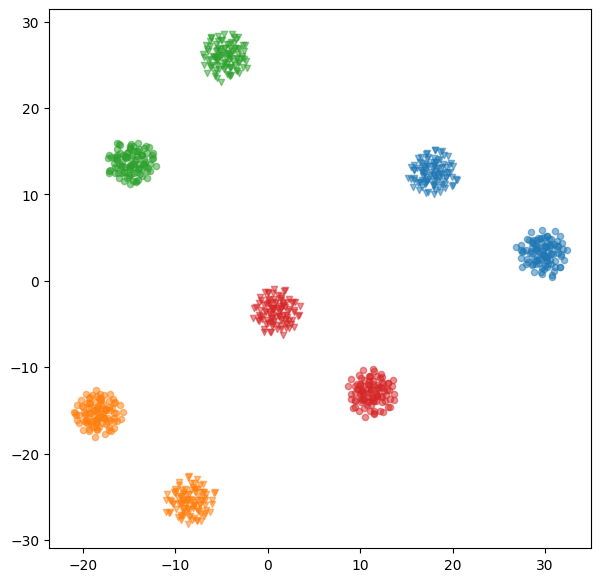

In [31]:
# We use the full hierarchy reps

# Demonstrate that divisive hierarchical clustering can reconstruct the hierarchy
subGCMClusters = cat.diana(subExemplars, cat.gcm_sim, max_clusters=None)
subGCMLinkage = subGCMClusters.linkage_matrix()

# Calculate dissimilarity matrix
subGCMSimMat = cat.default_gcm_sim_mat(subExemplars)
subGCMDistMat = 1 - subGCMSimMat

# Do MDS
tmp = MDS(
    n_components=2,
    dissimilarity="precomputed",
)
subGCMMDS = tmp.fit_transform(subGCMDistMat)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Every 200 dots change colors
colors = sns.color_palette(n_colors=4)
for i in range(4):
    # Every 100 dots change shapes
    for j in range(2):
        ax.scatter(
            subGCMMDS[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 0],
            subGCMMDS[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 1],
            s=20,
            alpha=0.5,
            color=colors[i],
            marker="o" if j == 0 else "v",
        )

# Do tsne
tmp = TSNE(n_components=2, metric="precomputed", init="random")
subGCMTSNE = tmp.fit_transform(subGCMDistMat)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Every 200 dots change colors
for i in range(4):
    # Every 100 dots change shapes
    for j in range(2):
        ax.scatter(
            subGCMTSNE[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 0],
            subGCMTSNE[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 1],
            s=20,
            alpha=0.5,
            color=colors[i],
            marker="o" if j == 0 else "v",
        )

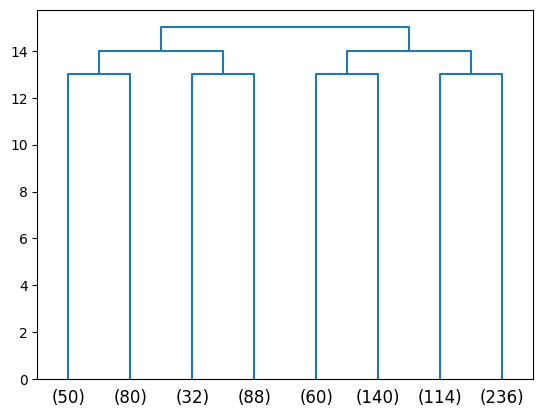

In [32]:
_ = dendrogram(subGCMLinkage, labels=subLabels, truncate_mode="level", p=2)

In [33]:
print_cluster_stats(subGCMClusters.tree, hierLabels, subExemplars)

Adjusted Rand score:
Level 1: -0.0010767212858009828
Level 2: -0.003240117735728062
Level 3: -0.00688033073197396
Adjusted Mutual information:
Level 1: -0.0009542144983344915
Level 2: -0.004200433241321132
Level 3: -0.015150026572061402
V-measure:
Level 1: 1.013722122955091e-15
Level 2: 5.088935509073812e-05
Level 3: 0.0008775767225459647
Fowlkes-Mallows:
Level 1: 0.5329095649197956
Level 2: 0.2718624173708124
Level 3: 0.13922991129723455
Davies-Bouldin:
Level 1: 69.83145951675947
Level 2: 47.79426368995599
Level 3: 31.298482096535846
Silhouette score:
Level 1: -0.0013802062021568418
Level 2: -0.0031671738252043724
Level 3: -0.006238360423594713
Calinski-Harabasz:
Level 1: 0.1404984729687168
Level 2: 0.2019993722105523
Level 3: 0.2708605225768043


In [34]:
print_category_metrics(subExemplars, hierLabels, subGCMSimMat, imgInfo)

Category cue validity = Sum(P(C|fk)) / n
Superordinate: 
Category:  0 Cue validity:  0.2456628417968745
Category:  1 Cue validity:  0.25374877929687484
Basic: 
Category:  0 Cue validity:  0.12283325195312493
Category:  1 Cue validity:  0.12282958984374998
Category:  2 Cue validity:  0.12727294921875004
Category:  3 Cue validity:  0.12647583007812502
Subordinate: 
Category:  0 Cue validity:  0.061433105468750006
Category:  1 Cue validity:  0.061400146484375084
Category:  2 Cue validity:  0.061446533203124945
Category:  3 Cue validity:  0.06138305664062495
Category:  4 Cue validity:  0.06277343750000001
Category:  5 Cue validity:  0.06449951171875004
Category:  6 Cue validity:  0.0629638671875
Category:  7 Cue validity:  0.06351196289062497

Category validity = Sum(P(fk|C)) / n
Superordinate: 
Category:  0  Validity:  0.491325683593749
Category:  1  Validity:  0.5074975585937497
Basic: 
Category:  0  Validity:  0.4913330078124997
Category:  1  Validity:  0.4913183593749999
Category:  2  

# Simulate basic level categories


In [20]:
# Create simulated categories without subordinate category separation
basicExemplars, basicCentroids = cat.make_categories(
    cat_rad=1,
    super_rad=1,
    basic_rad=0.5,
    sub_rad=0.0,
    nFeatures=1024,
    nImages=100,
    relu=True,
    radius_density="power",
)

# Demonstrate that divisive hierarchical clustering can reconstruct the hierarchy
basicClusters = cat.diana(basicExemplars, "euclidean", max_clusters=None)
basicLinkage = basicClusters.linkage_matrix()

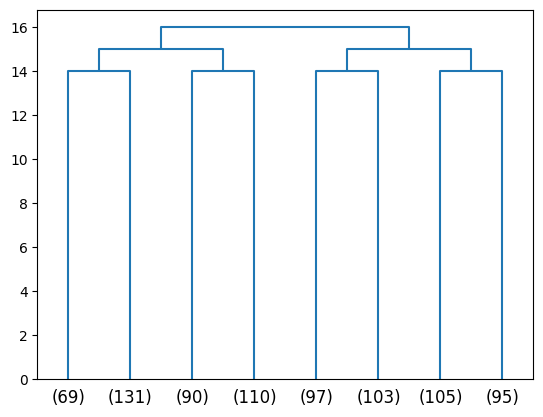

In [17]:
_ = dendrogram(basicLinkage, labels=subLabels, truncate_mode="level", p=2)

In [21]:
print_cluster_stats(basicClusters.tree, hierLabels, basicExemplars)

Adjusted Rand score:
Level 1: 1.0
Level 2: 1.0
Level 3: 0.4290889052957968
Adjusted Mutual information:
Level 1: 1.0
Level 2: 1.0
Level 3: 0.6637337420972549
V-measure:
Level 1: 1.0
Level 2: 1.0
Level 3: 0.6687830448175957
Fowlkes-Mallows:
Level 1: 1.0
Level 2: 1.0
Level 3: 0.5001884471037948
Davies-Bouldin:
Level 1: 1.378848463853438
Level 2: 2.1721349191007095
Level 3: 10.044931131280226
Silhouette score:
Level 1: 0.3035290241241455
Level 2: 0.15977783501148224
Level 3: 0.004714587237685919
Calinski-Harabasz:
Level 1: 419.4182503523114
Level 2: 225.31022923714303
Level 3: 98.12783227845408


In [22]:
print_category_metrics(basicExemplars, hierLabels, subSimMat, imgInfo)

Category cue validity = Sum(P(C|fk)) / n
Superordinate: 
Category:  0 Cue validity:  0.24638793945312512
Category:  1 Cue validity:  0.25301147460937523
Basic: 
Category:  0 Cue validity:  0.12343749999999992
Category:  1 Cue validity:  0.12295043945312502
Category:  2 Cue validity:  0.1284020996093749
Category:  3 Cue validity:  0.12460937500000012
Subordinate: 
Category:  0 Cue validity:  0.06172607421874999
Category:  1 Cue validity:  0.06171142578125
Category:  2 Cue validity:  0.06162231445312498
Category:  3 Cue validity:  0.061328125000000004
Category:  4 Cue validity:  0.06418457031249994
Category:  5 Cue validity:  0.064217529296875
Category:  6 Cue validity:  0.06235229492187504
Category:  7 Cue validity:  0.06225708007812499

Category validity = Sum(P(fk|C)) / n
Superordinate: 
Category:  0  Validity:  0.49277587890625024
Category:  1  Validity:  0.5060229492187505
Basic: 
Category:  0  Validity:  0.4937499999999997
Category:  1  Validity:  0.4918017578125001
Category:  2  V

# Sweep across different hyper parameters


In [175]:
superSteps = 10
basicSteps = 10
subSteps = 10

superRads = np.linspace(0.1, 3, superSteps)
basicRads = np.linspace(0.1, 2, basicSteps)
subRads = np.linspace(0.1, 1.5, subSteps)

# Preallocate array to store results
winner = np.zeros((superSteps, basicSteps, subSteps))
winnerBy = np.zeros((superSteps, basicSteps, subSteps))
superIdxs = np.zeros((superSteps, basicSteps, subSteps))
basicIdxs = np.zeros((superSteps, basicSteps, subSteps))
subIdxs = np.zeros((superSteps, basicSteps, subSteps))

# Go through combinations of all three
for i, superRad in enumerate(superRads):
    for j, basicRad in enumerate(basicRads):
        for k, subRad in enumerate(subRads):
            # Create exemplars
            exemplars, _ = cat.make_categories(
                cat_rad=1,
                super_rad=superRad,
                basic_rad=basicRad,
                sub_rad=subRad,
                nFeatures=1024,
                nImages=100,
                relu=True,
                radius_density="power",
            )

            # Calculate similarity matrix
            simMat = dist.squareform(dist.pdist(exemplars, metric="euclidean"))
            simMat = 1 / (1 + simMat)

            simCluster = cat.SimCluster(simMat=simMat, imgInfo=imgInfo)
            clusterIndices = np.zeros((3,))
            clusterIndices[0] = simCluster.calculate_index(level="super")
            clusterIndices[1] = simCluster.calculate_index(level="basic")
            clusterIndices[2] = simCluster.calculate_index(level="sub")

            # Save indices
            superIdxs[i, j, k] = clusterIndices[0]
            basicIdxs[i, j, k] = clusterIndices[1]
            subIdxs[i, j, k] = clusterIndices[2]

            # Find winners/second
            clusterRanks = np.argsort(clusterIndices)

            # Record winner
            winner[i, j, k] = clusterRanks[2]

            # Record winner by
            winnerBy[i, j, k] = (
                clusterIndices[clusterRanks[2]] - clusterIndices[clusterRanks[1]]
            )

# Count unique winners
unique, counts = np.unique(winner, return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 163, 1.0: 296, 2.0: 541}


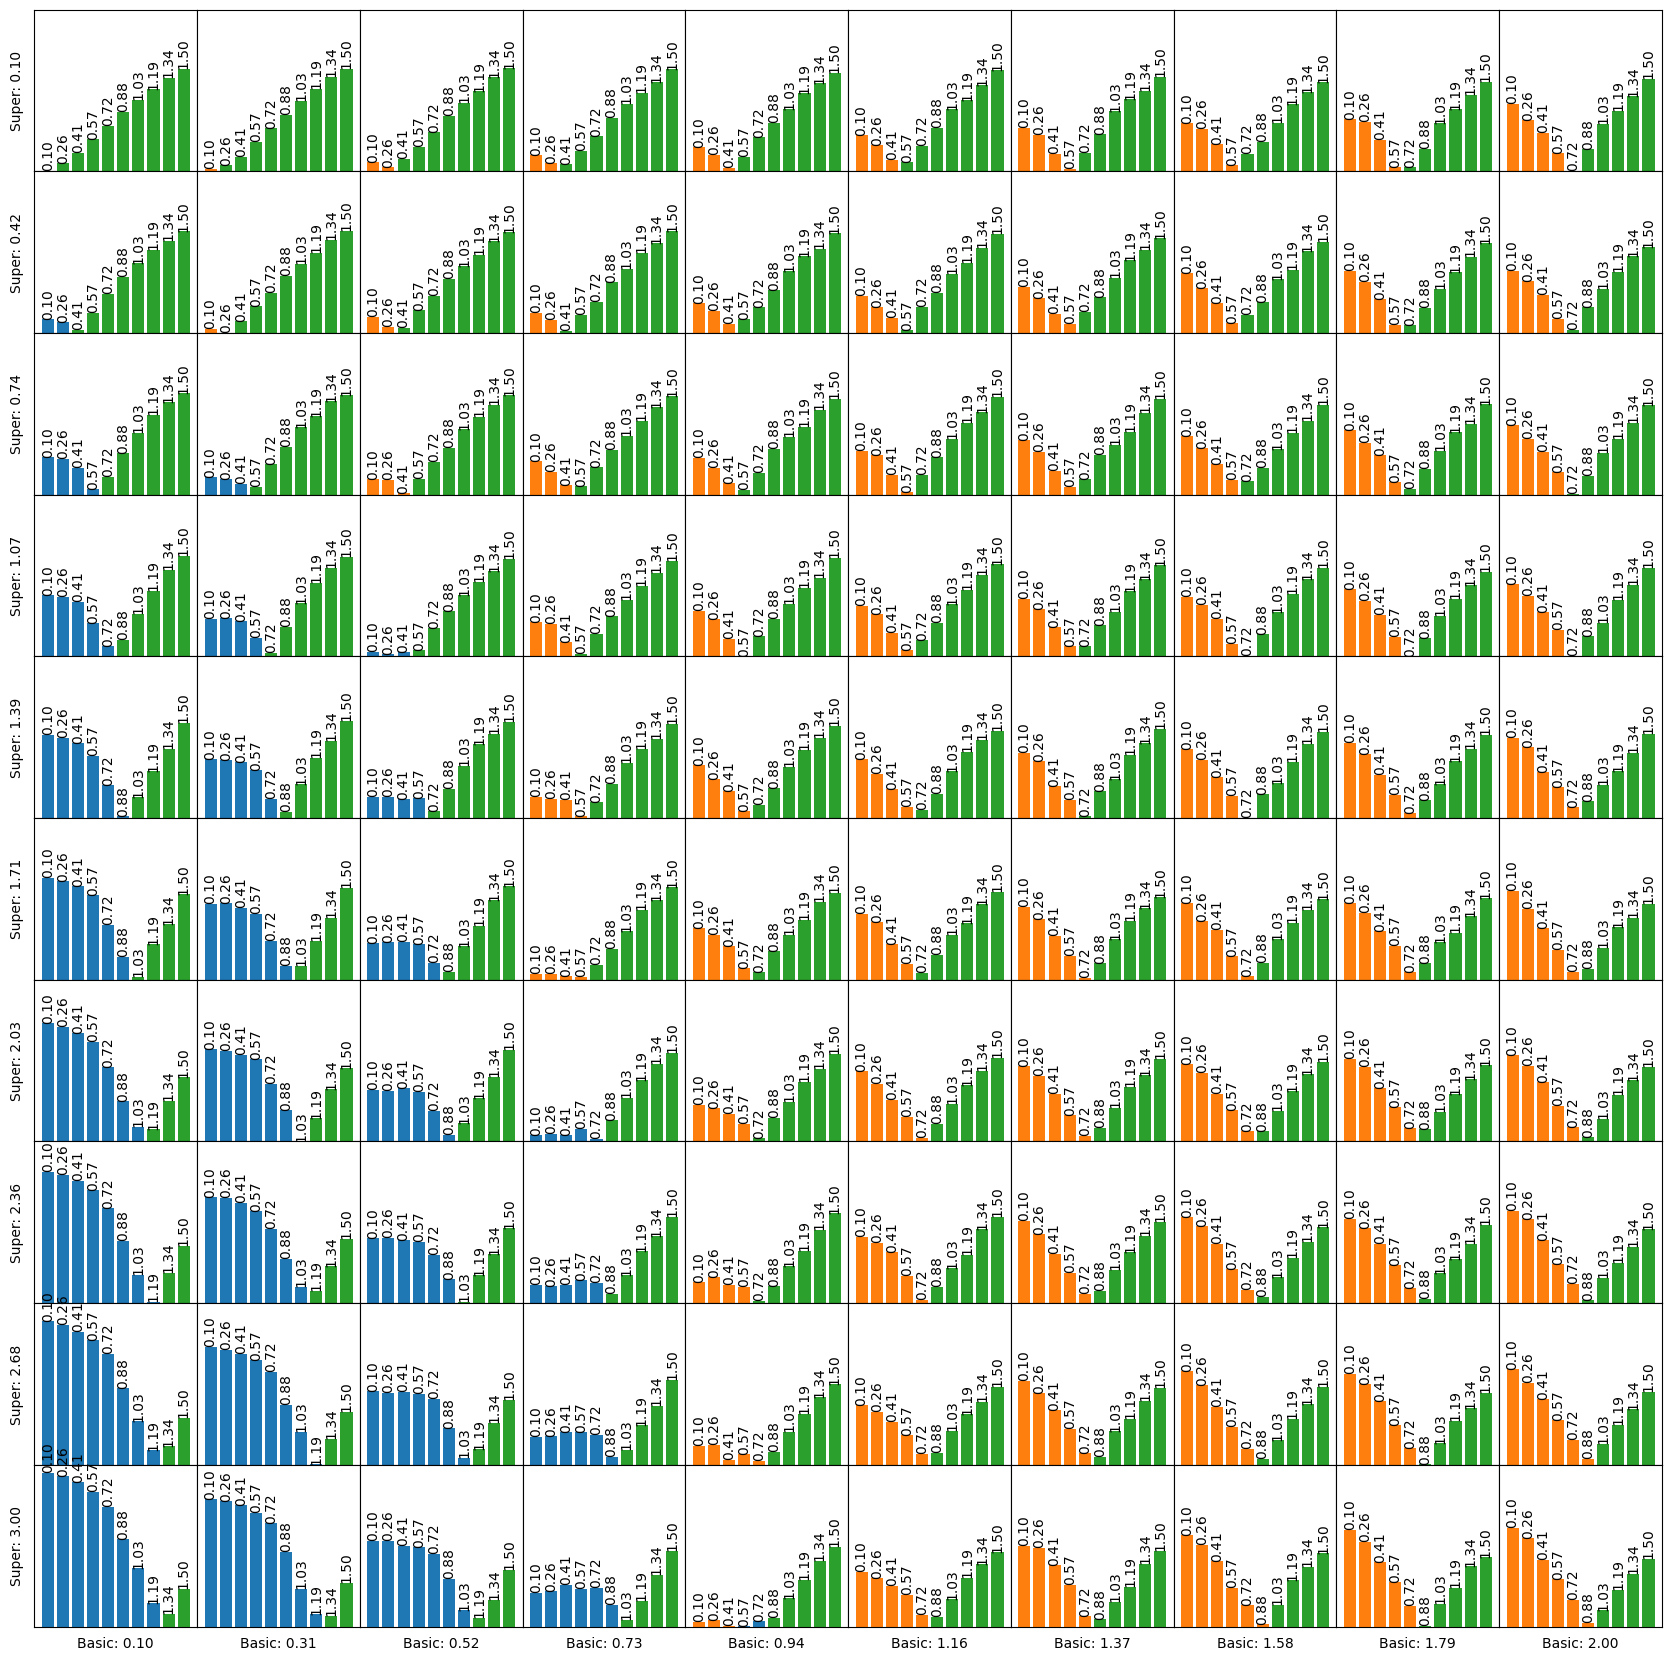

In [176]:
# Colors
colors = sns.color_palette(n_colors=3)

# Plot 10 x 10 x 10 grid of winners
fig, axs = plt.subplots(
    superSteps, basicSteps, figsize=(21, 21), sharex=True, sharey=True
)

for i in range(superSteps):  # Super
    for j in range(basicSteps):  # Basic
        for k in range(subSteps):  # Subordinate
            axs[i][j].bar(
                x=k, height=winnerBy[i, j, k], color=colors[int(winner[i, j, k])]
            )

            # Draw rotated text on top of the bar
            axs[i][j].text(
                k,
                winnerBy[i, j, k],
                f"{subRads[k]:.2f}",
                ha="center",
                va="bottom",
                color="black",
                rotation=90,
            )

            # Remove axis labels
            axs[i][j].set_xticks([])
            axs[i][j].set_yticks([])

            # If this plot is on the left, add a label
            if j == 0:
                axs[i][j].set_ylabel(f"Super: {superRads[i]:.2f}")

            # If this plot is on the bottom, add a label
            if i == basicSteps - 1:
                axs[i][j].set_xlabel(f"Basic: {basicRads[j]:.2f}")

# Remove gaps between subplots
fig.subplots_adjust(hspace=0, wspace=0)

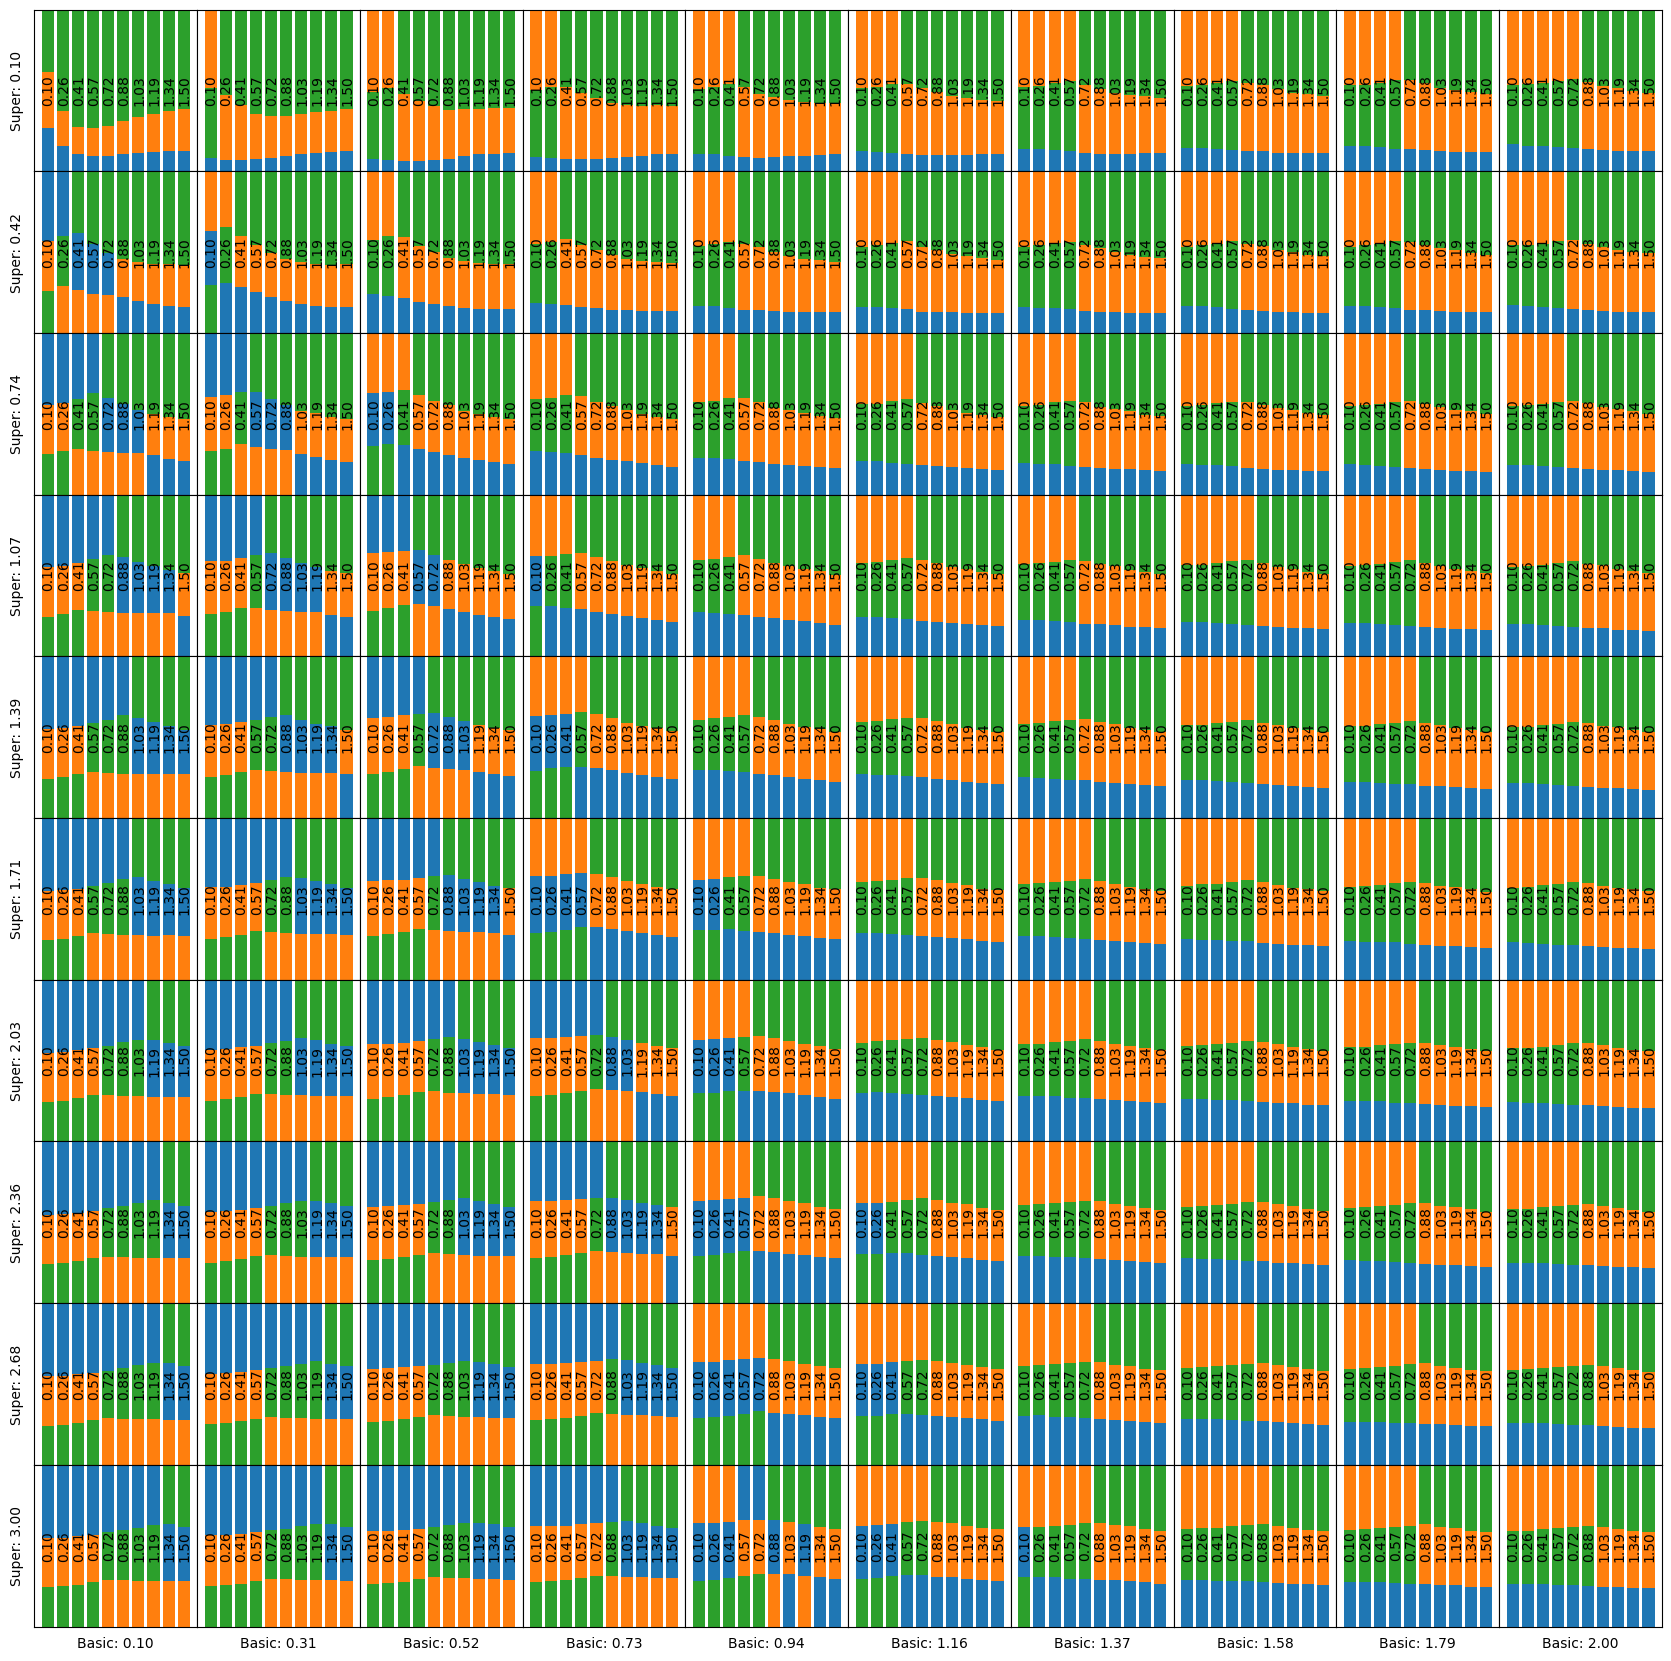

In [196]:
# Preprocess data
totalIdxs = superIdxs + basicIdxs + subIdxs
superRelIdxs = superIdxs / totalIdxs
basicRelIdxs = basicIdxs / totalIdxs
subRelIdxs = subIdxs / totalIdxs

# Colors
colors = sns.color_palette(n_colors=3)

# Plot grid of relative cluster indices
fig, axs = plt.subplots(
    superSteps, basicSteps, figsize=(21, 21), sharex=True, sharey=True
)

for i in range(superSteps):  # Super
    for j in range(basicSteps):  # Basic
        for k in range(subSteps):  # Subordinate
            # Get values for this plot
            superVal = superRelIdxs[i, j, k]
            basicVal = basicRelIdxs[i, j, k]
            subVal = subRelIdxs[i, j, k]

            # Plot the loser first
            if superVal < basicVal and superVal < subVal:
                barHeight = superVal
                axs[i][j].bar(x=k, height=barHeight, color=colors[0])
            elif basicVal < superVal and basicVal < subVal:
                barHeight = basicVal
                axs[i][j].bar(x=k, height=barHeight, color=colors[1])
            elif subVal < superVal and subVal < basicVal:
                barHeight = subVal
                axs[i][j].bar(x=k, height=barHeight, color=colors[2])

            # Plot the next highest value on top
            if basicVal > superVal > subVal or basicVal < superVal < subVal:
                axs[i][j].bar(
                    x=k, height=barHeight + superVal, bottom=barHeight, color=colors[0]
                )
                barHeight += superVal
            elif superVal > basicVal > subVal or superVal < basicVal < subVal:
                axs[i][j].bar(
                    x=k, height=barHeight + basicVal, bottom=barHeight, color=colors[1]
                )
                barHeight += basicVal
            elif basicVal > subVal > superVal or basicVal < subVal < superVal:
                axs[i][j].bar(
                    x=k, height=barHeight + subVal, bottom=barHeight, color=colors[2]
                )
                barHeight += subVal

            # Plot the highest value on top
            if superVal > basicVal and superVal > subVal:
                axs[i][j].bar(
                    x=k, height=barHeight + superVal, bottom=barHeight, color=colors[0]
                )
            elif basicVal > superVal and basicVal > subVal:
                axs[i][j].bar(
                    x=k, height=barHeight + basicVal, bottom=barHeight, color=colors[1]
                )
            elif subVal > superVal and subVal > basicVal:
                axs[i][j].bar(
                    x=k, height=barHeight + subVal, bottom=barHeight, color=colors[2]
                )

            # Draw rotated text in the middle of the bars
            axs[i][j].text(
                k + 0.05,
                0.5,
                f"{subRads[k]:.2f}",
                ha="center",
                va="center",
                color="black",
                rotation=90,
            )

            # Set axis limits
            axs[i][j].set_ylim([0, 1])

            # Remove axis labels
            axs[i][j].set_xticks([])
            axs[i][j].set_yticks([])

            # If this plot is on the left, add a label
            if j == 0:
                axs[i][j].set_ylabel(f"Super: {superRads[i]:.2f}")

            # If this plot is on the bottom, add a label
            if i == basicSteps - 1:
                axs[i][j].set_xlabel(f"Basic: {basicRads[j]:.2f}")

# Remove gaps between subplots
fig.subplots_adjust(hspace=0, wspace=0)

In [170]:
# Create simulated categories
testExemplars, testCentroids = cat.make_categories(
    cat_rad=1,
    super_rad=2.03,
    basic_rad=2.03,
    sub_rad=0.1,
    nFeatures=1024,
    nImages=100,
    relu=True,
    radius_density="power",
)

In [171]:
testDistMat = dist.squareform(dist.pdist(testExemplars, metric="euclidean"))
testSimMat = 1 / (1 + testDistMat)

print("Cluster index (mean within sim - mean betwen sim)")
simCluster = cat.SimCluster(simMat=testSimMat, imgInfo=imgInfo)

print("Superordinate: ")
print(simCluster.calculate_index(level="super"))

print("Basic: ")
print(simCluster.calculate_index(level="basic"))

print("Subordinate: ")
print(simCluster.calculate_index(level="sub"))

Cluster index (mean within sim - mean betwen sim)
Superordinate: 
0.13822722
Basic: 
0.24481992
Subordinate: 
0.19363973


# Real Ecoset representations


In [2]:
ecosetRepFile = "./representations/ecosetReps.npy"
ecosetReps = np.load(ecosetRepFile)
ecosetReps.shape  # Model, image, rep, rep, rep

# Only keep the first model
ecosetReps = ecosetReps[0, :, :, :, :]

# Apply global average pooling
ecosetRepsAvg = np.mean(ecosetReps, axis=(1, 2))

In [3]:
# Apply divisive hierarchical clustering
ecosetClusters = cat.diana(ecosetRepsAvg, "euclidean", max_clusters=None)
ecosetLinkage = ecosetClusters.linkage_matrix()

KeyboardInterrupt: 

/data/venv/research2/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


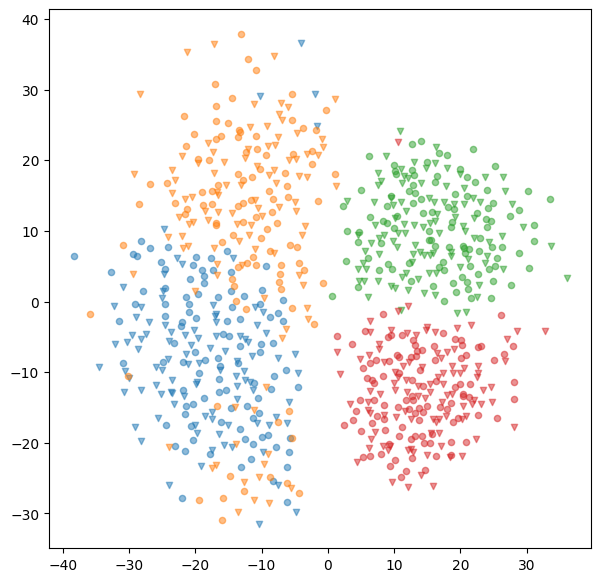

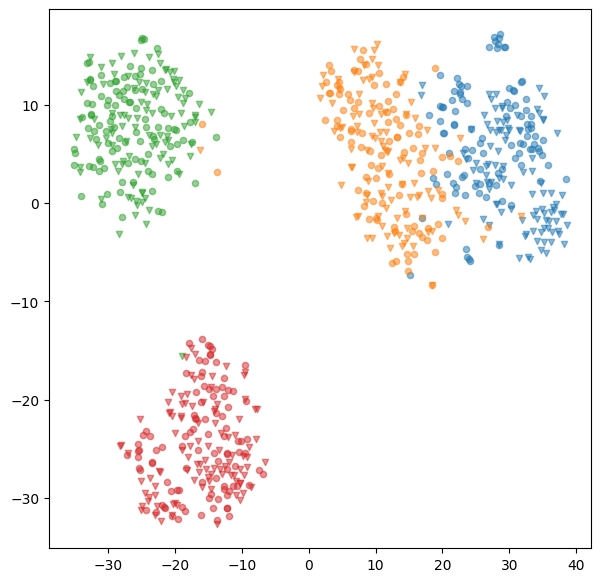

In [24]:
# Calculate similarity matrix
ecosetDistMat = dist.squareform(dist.pdist(ecosetRepsAvg, metric="euclidean"))
ecosetSimMat = 1 / (1 + ecosetDistMat)

# Do MDS
tmp = MDS(
    n_components=2,
    dissimilarity="precomputed",
)
ecosetMDS = tmp.fit_transform(ecosetDistMat)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Every 200 dots change colors
colors = sns.color_palette(n_colors=4)
for i in range(4):
    # Every 100 dots change shapes
    for j in range(2):
        ax.scatter(
            ecosetMDS[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 0],
            ecosetMDS[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 1],
            s=20,
            alpha=0.5,
            color=colors[i],
            marker="o" if j == 0 else "v",
        )

# Do tsne
tmp = TSNE(n_components=2, metric="precomputed", init="random")
ecosetTSNE = tmp.fit_transform(ecosetDistMat)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Every 200 dots change colors
for i in range(4):
    # Every 100 dots change shapes
    for j in range(2):
        ax.scatter(
            ecosetTSNE[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 0],
            ecosetTSNE[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 1],
            s=20,
            alpha=0.5,
            color=colors[i],
            marker="o" if j == 0 else "v",
        )

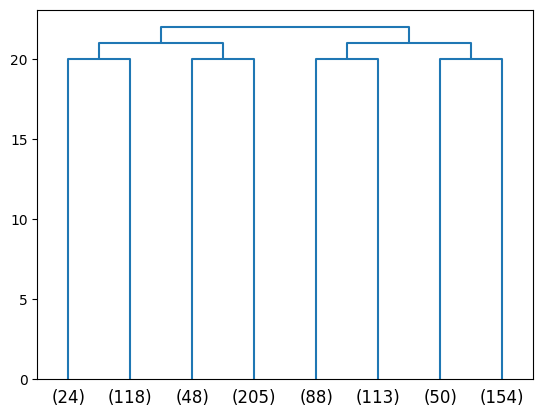

In [26]:
# Create dendrogram
_ = dendrogram(ecosetLinkage, labels=subLabels, truncate_mode="level", p=2)

In [41]:
print_cluster_stats(ecosetClusters.tree, hierLabels, ecosetRepsAvg)

Adjusted Rand score:
Level 1: 0.975125122351754
Level 2: 0.8179975226613547
Level 3: 0.40215678095589685
Adjusted Mutual information:
Level 1: 0.9514247207854727
Level 2: 0.8421535598498443
Level 3: 0.6036238228292529
V-measure:
Level 1: 0.9514686051547183
Level 2: 0.8428022215758587
Level 3: 0.6099091207801788
Fowlkes-Mallows:
Level 1: 0.987547970762765
Level 2: 0.8643489340570636
Level 3: 0.4912887842490066
Davies-Bouldin:
Level 1: 1.9327618047750605
Level 2: 2.478047460631339
Level 3: 3.1556719708297267
Silhouette score:
Level 1: 0.19434402883052826
Level 2: 0.1391259729862213
Level 3: 0.07052186131477356
Calinski-Harabasz:
Level 1: 208.45696672276898
Level 2: 123.46665404255634
Level 3: 64.66422827238364


In [25]:
print_category_metrics(ecosetRepsAvg, hierLabels, ecosetSimMat, imgInfo)

Category cue validity = Sum(P(C|fk)) / n
Superordinate: 
Category:  0 Cue validity:  0.32880828857421845
Category:  1 Cue validity:  0.29179687499999896
Basic: 
Category:  0 Cue validity:  0.1704263305664064
Category:  1 Cue validity:  0.1583819580078127
Category:  2 Cue validity:  0.14808166503906206
Category:  3 Cue validity:  0.14371520996093703
Subordinate: 
Category:  0 Cue validity:  0.08553466796874991
Category:  1 Cue validity:  0.08489166259765611
Category:  2 Cue validity:  0.07866241455078117
Category:  3 Cue validity:  0.07971954345703125
Category:  4 Cue validity:  0.07279632568359375
Category:  5 Cue validity:  0.07528533935546844
Category:  6 Cue validity:  0.07229461669921881
Category:  7 Cue validity:  0.07142059326171876

Category validity = Sum(P(fk|C)) / n
Superordinate: 
Category:  0  Validity:  0.6576165771484369
Category:  1  Validity:  0.5835937499999979
Basic: 
Category:  0  Validity:  0.6817053222656256
Category:  1  Validity:  0.6335278320312508
Category:  2 

<AxesSubplot: ylabel='Count'>

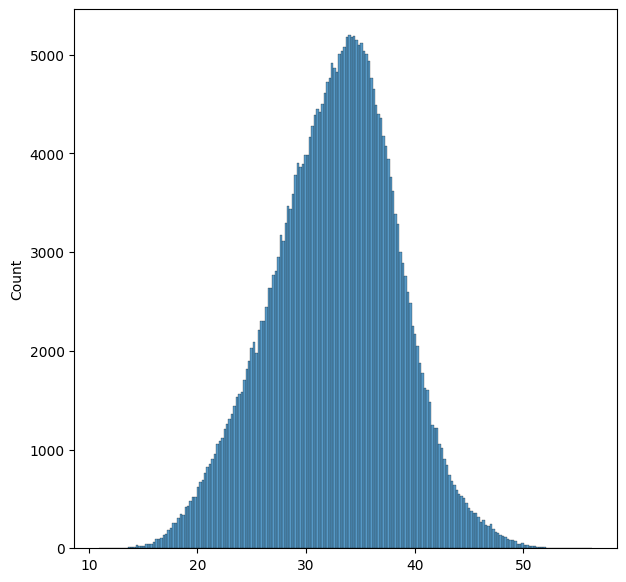

In [4]:
# Plot histogram of similarity scores
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.histplot(dist.pdist(ecosetRepsAvg, metric="euclidean"))

--- SANDBOX


/data/venv/research2/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


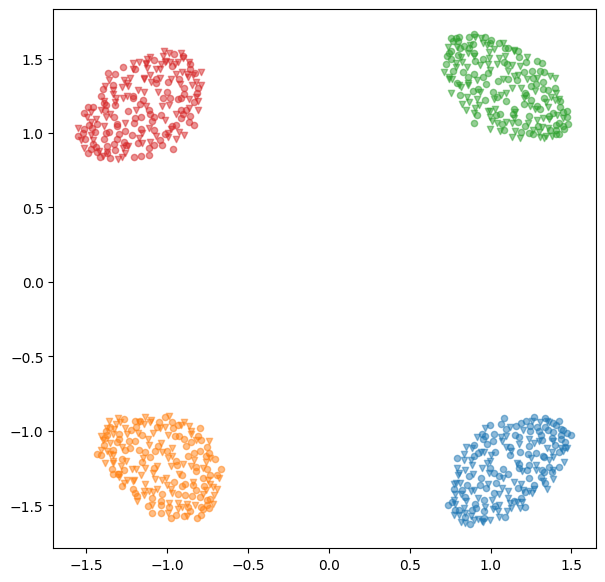

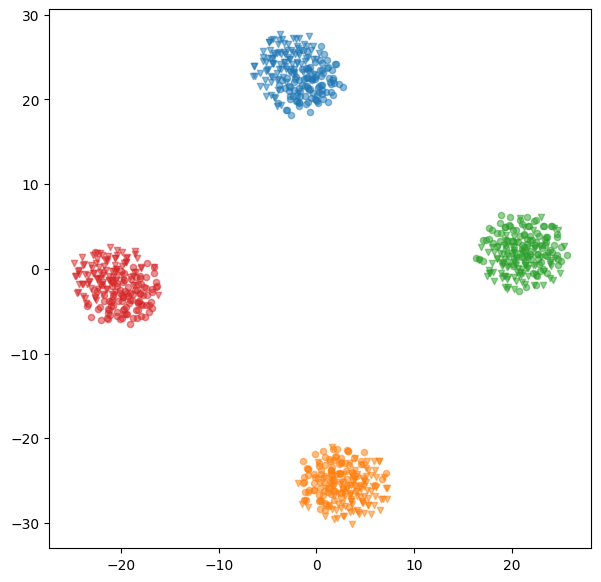

In [172]:
# Demonstrate that divisive hierarchical clustering can reconstruct the hierarchy
testClusters = cat.myIPDDP().fit(testExemplars)
testLinkage = testClusters.linkage_matrix(dist_metric="euclidean")

# Calculate dissimilarity matrix
testDistMat = dist.squareform(dist.pdist(testExemplars, metric="euclidean"))
testSimMat = 1 / (1 + testDistMat)

# Do MDS
tmp = MDS(
    n_components=2,
    dissimilarity="precomputed",
)
testMDS = tmp.fit_transform(testDistMat)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Every 200 dots change colors
colors = sns.color_palette(n_colors=4)
for i in range(4):
    # Every 100 dots change shapes
    for j in range(2):
        ax.scatter(
            testMDS[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 0],
            testMDS[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 1],
            s=20,
            alpha=0.5,
            color=colors[i],
            marker="o" if j == 0 else "v",
        )

# Do tsne
tmp = TSNE(n_components=2, metric="precomputed", init="random")
testTSNE = tmp.fit_transform(testDistMat)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Every 200 dots change colors
for i in range(4):
    # Every 100 dots change shapes
    for j in range(2):
        ax.scatter(
            testTSNE[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 0],
            testTSNE[(i * 200 + j * 100) : (i * 200 + j * 100 + 100), 1],
            s=20,
            alpha=0.5,
            color=colors[i],
            marker="o" if j == 0 else "v",
        )

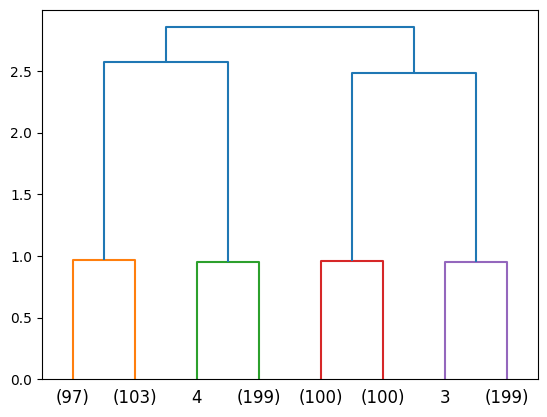

In [173]:
_ = dendrogram(testLinkage, labels=subLabels, truncate_mode="level", p=2)

In [174]:
print_cluster_stats(testClusters.tree, hierLabels, testExemplars)

Adjusted Rand score:
Level 1: 1.0
Level 2: 1.0
Level 3: 0.4607374412150871
Adjusted Mutual information:
Level 1: 1.0
Level 2: 1.0
Level 3: 0.7672724191989607
V-measure:
Level 1: 1.0
Level 2: 1.0
Level 3: 0.7696617359385854
Fowlkes-Mallows:
Level 1: 1.0
Level 2: 1.0
Level 3: 0.6165872548406572
Davies-Bouldin:
Level 1: 1.271220954412255
Level 2: 0.5739635647492252
Level 3: 6.660785292508915
Silhouette score:
Level 1: 0.3899376690387726
Level 2: 0.6230216026306152
Level 3: 0.12731090188026428
Calinski-Harabasz:
Level 1: 493.56169041302314
Level 2: 1468.4790338447895
Level 3: 232.4380068056624
